In [190]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

In [191]:
# this allows changing the code in external packages and having the changes take effect in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [292]:
from smart_fuel_acquisitons.data import create_features_and_targets, create_features_and_targets_on_days_for_month, create_features_and_targets_for_month, predict_until_end

# Tratamento de Dados

In [193]:
# Arquivo Excel
from pathlib import Path
file_path = Path('Dados') / 'ISEG_Bloomberg' / 'Dados.xlsx'


In [194]:
# Função para ler e limpar dados de uma folha específica, tratando colunas extras
def read_sheet(sheet_name, col_name):
    data = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=6)
    data = data.iloc[:, [0, 1]]  # Seleciona apenas as duas primeiras colunas relevantes
    data.columns = ['Date', col_name]
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data = data.dropna().set_index('Date')
    data = data.shift(1).dropna()  # Desloca os preços uma linha para baixo
    return data

Relativamente aos dados presentes em cada folha de Excel deslocou-se uma linha para baixo (close price), porque quando os dados foram extraídos da Bloomberg no dia 17/07/2024 e o dia ainda não tinha terminado, ou seja, o close price do dia 17/07 era o close price do dia anterior e assim sucessivamente, até ao close price mais antigo.

In [195]:
# Ler os dados das várias folhas com os nomes das colunas corrigidos (removendo Brent)
wti_data = read_sheet('WTI Crude Oil', 'WTI Crude Oil Prices')
sp500_data = read_sheet('S&P500', 'S&P500')
gold_data = read_sheet('Gold', 'Gold')
silver_data = read_sheet('Silver', 'Silver')
eurusd_data = read_sheet('EURUSD', 'EUR/USD')
eurrub_data = read_sheet('EURRUB', 'EUR/RUB')

Depois de ter usado todas as variáveis extraídas da Bloomberg e de as ter correlacionado decidi optar apenas por estas, tendo como variável dependente o WTI Crude Oil. O Jet Fuel NWE CIF Cargoes tem, tal como o Brent e como era de esperar, uma correlação de 0.99 com o WTI, no entanto, tem dados apenas desde 2008. A Bitcoin tem dados desde 2010 e tinha uma correlação de 0.10. A taxa de câmbio USD/RUB não tinha dados a partir de 2022 e ambas as moedas estão expostas ao EUR que mostra uma correlação considerável, daí ter optado por retirar do modelo. Por fim, as variáveis total crude oil supply & demand foram retiradas porque, apesar de terem uma correlação aparentemente considerável, têm apenas dados mensais e trimestrais.

In [196]:
# Combinar todas as folhas em um único DataFrame
combined_data = wti_data.join([sp500_data, gold_data, silver_data, eurusd_data, eurrub_data], how='outer')
combined_data.dropna(inplace=True)

## Closing Prices das 6 variáveis s/ Brent

In [197]:
# Exibir os primeiros 5 registros
print(combined_data.head())

            WTI Crude Oil Prices  S&P500    Gold  Silver  EUR/USD  EUR/RUB
Date                                                                      
1994-01-04                 14.67  466.89  393.85    5.24   1.1246   1.1088
1994-01-05                 15.34  467.55  391.20    5.09   1.1252   1.1154
1994-01-06                 15.42  467.12  388.90    5.12   1.1252   1.1189
1994-01-07                 15.32  469.90  387.10    5.01   1.1293   1.1148
1994-01-10                 14.67  475.27  384.60    5.04   1.1269   1.1305


## Dados (1994-2024)

In [198]:
# Filtrar os dados entre as datas de 1994 e 2024
start_date = '1994-01-04'
end_date = '2024-07-15'
filtered_data = combined_data[(combined_data.index >= start_date) & (combined_data.index <= end_date)]

In [199]:
# Função para plotar cada variável
def plot_variable(data, variable_name):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data[variable_name], label=variable_name)
    plt.title(f'{variable_name} (1994 - 2024)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

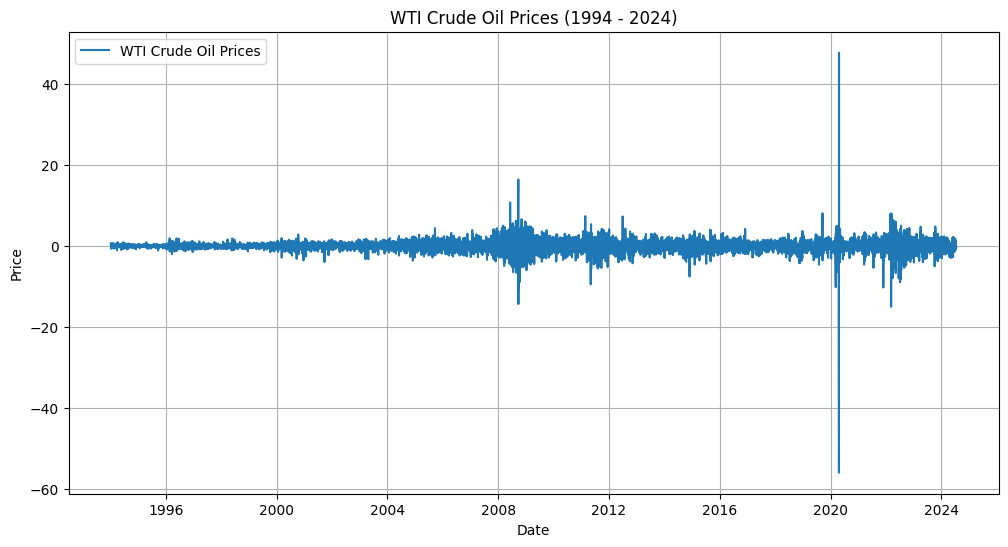

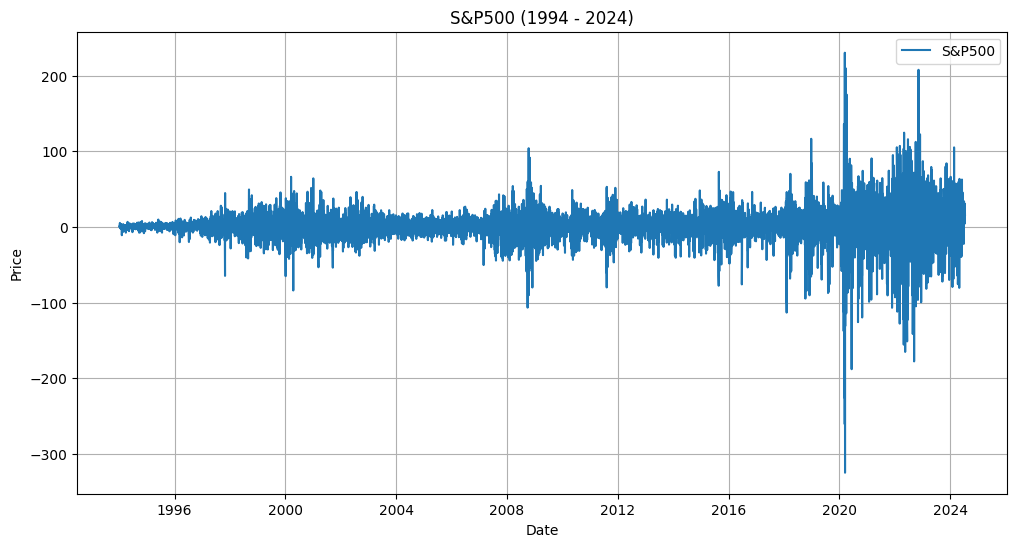

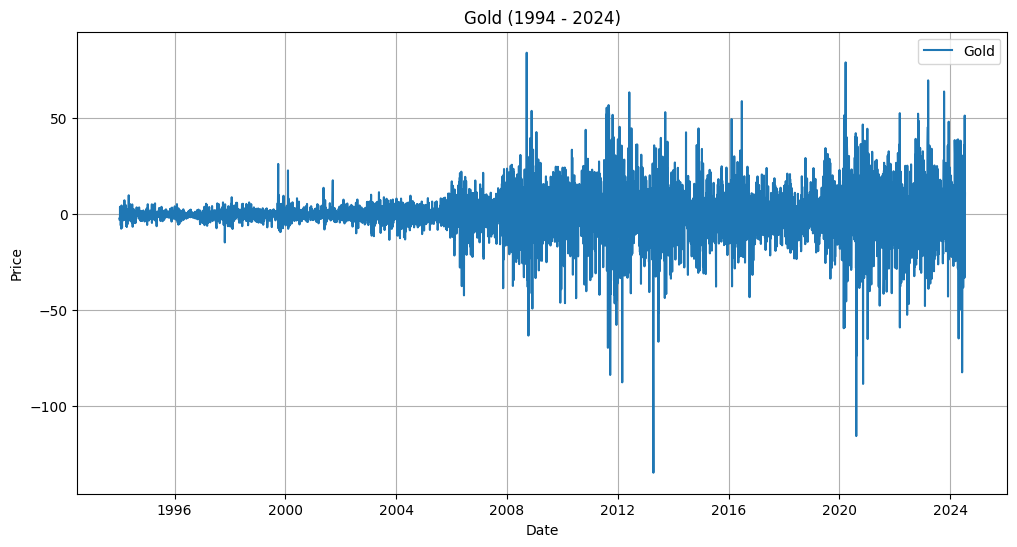

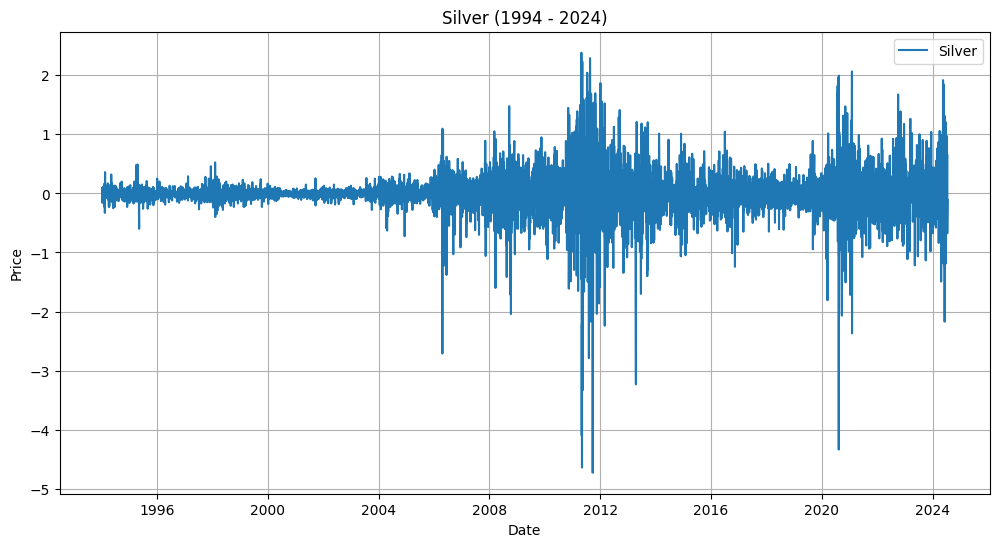

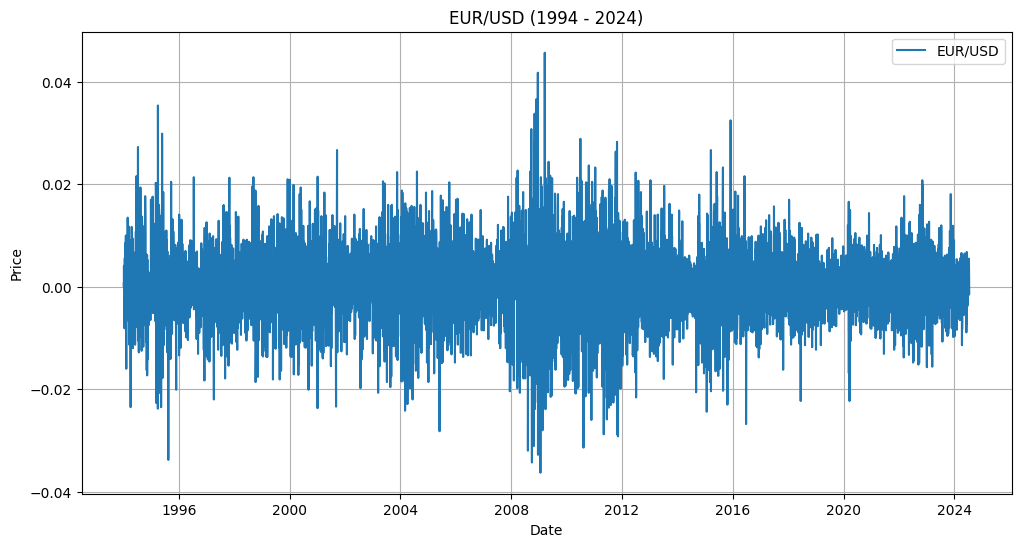

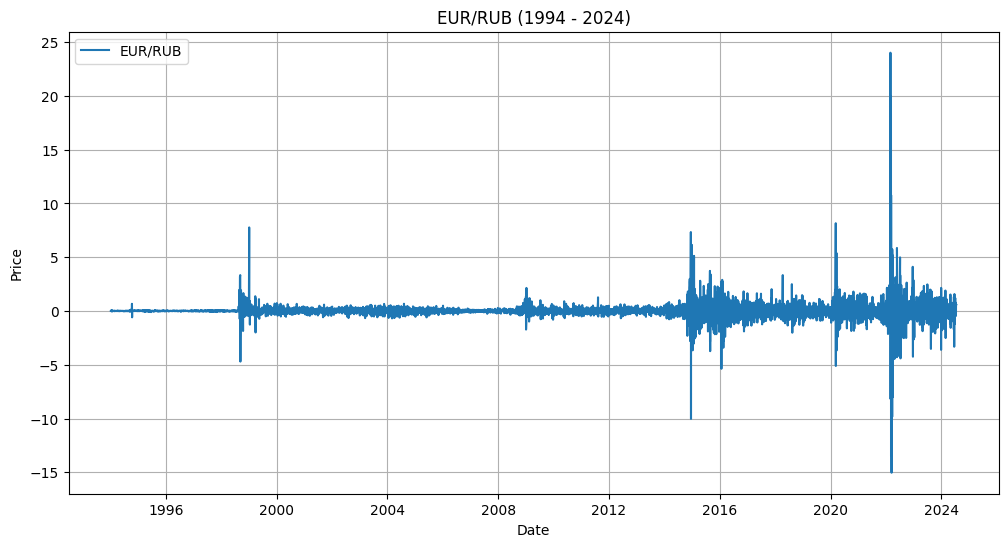

In [200]:
dif_data = filtered_data.diff().dropna()
for col in dif_data.columns:
    plot_variable(dif_data, col)


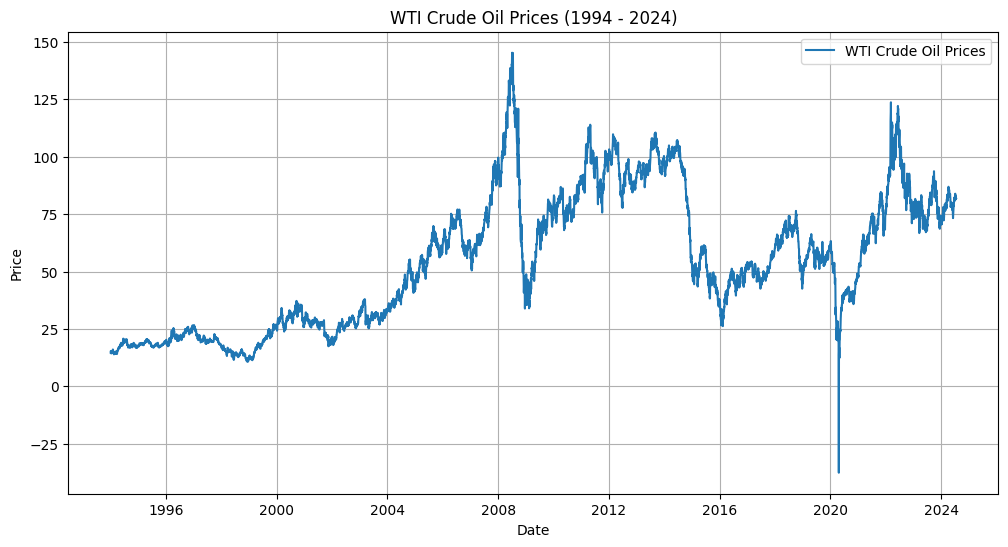

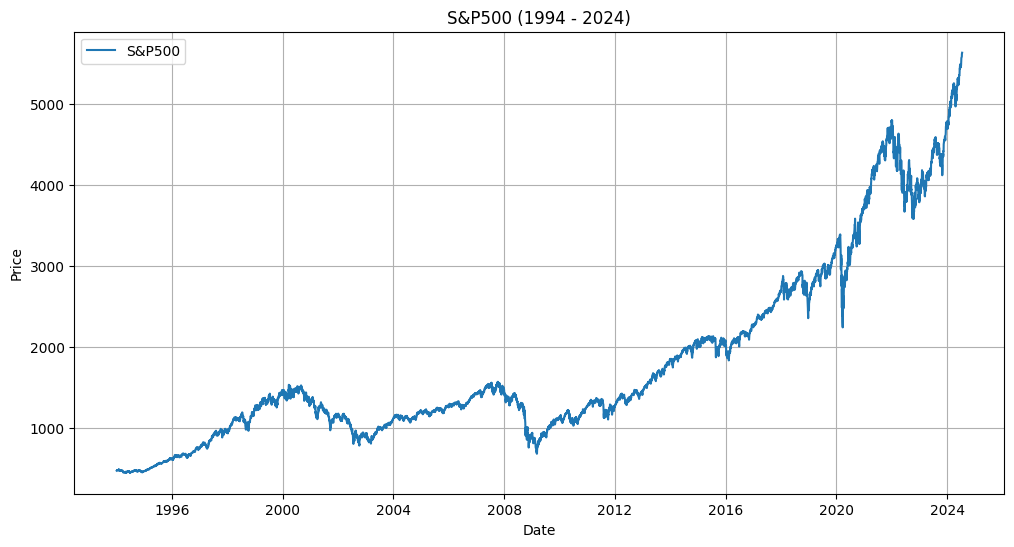

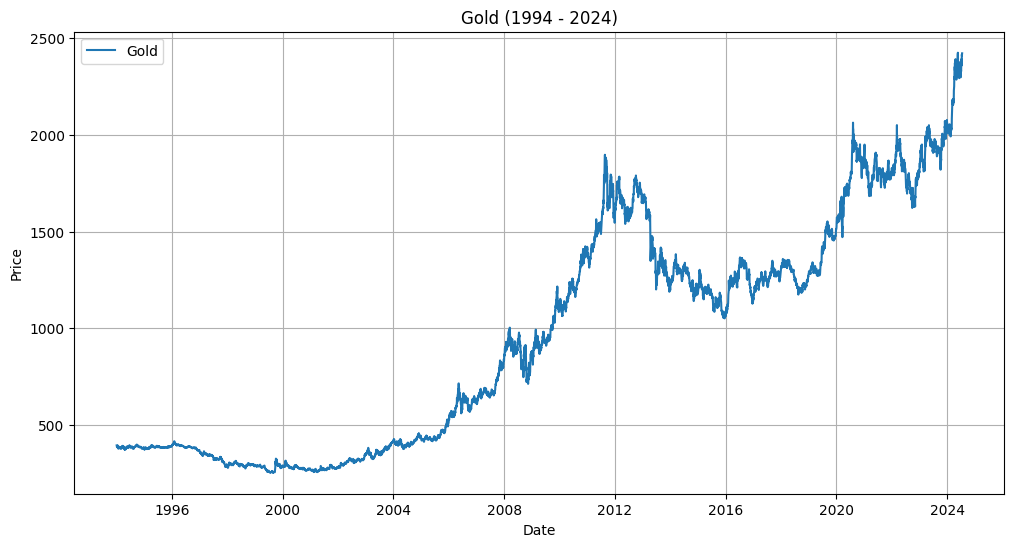

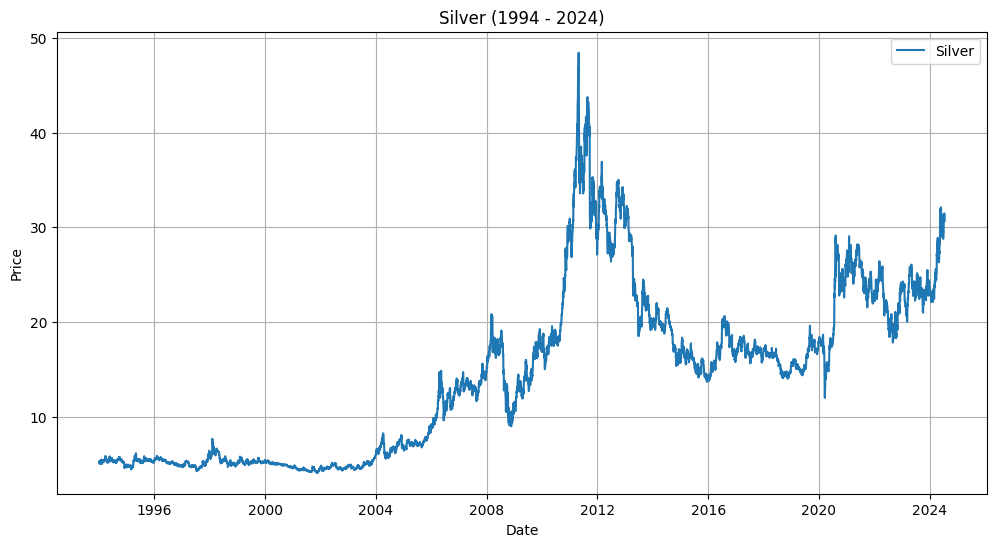

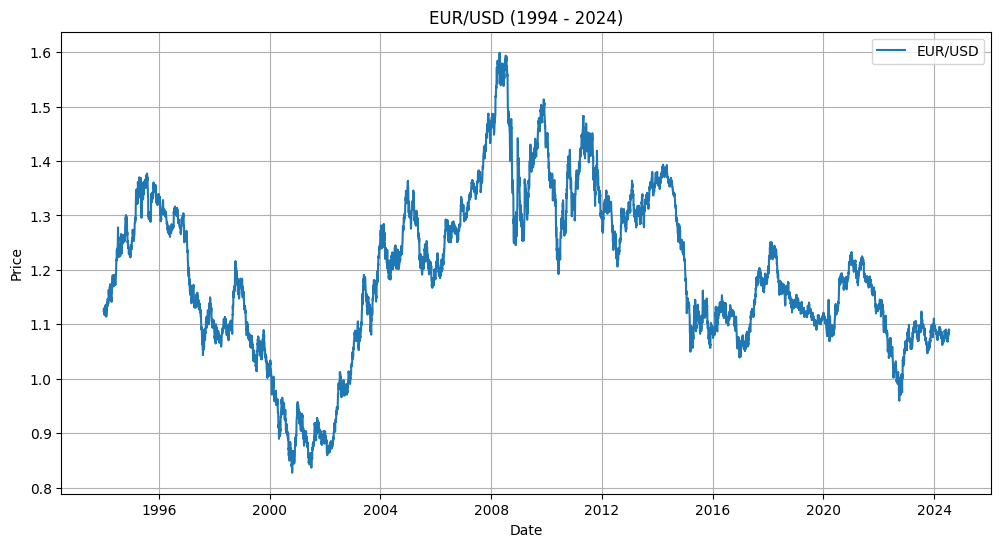

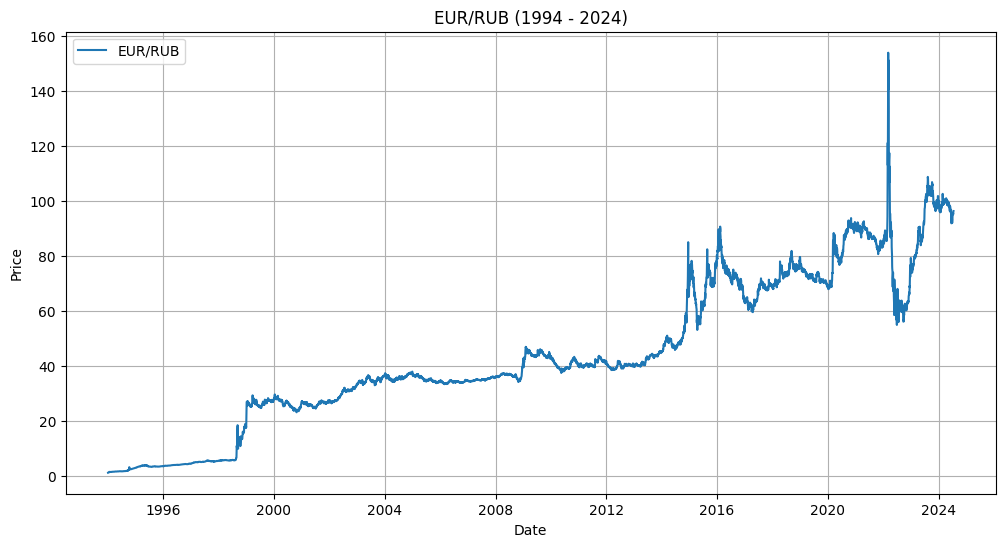

In [201]:
for col in filtered_data.columns:
    plot_variable(filtered_data, col)

## Gráficos das variáveis

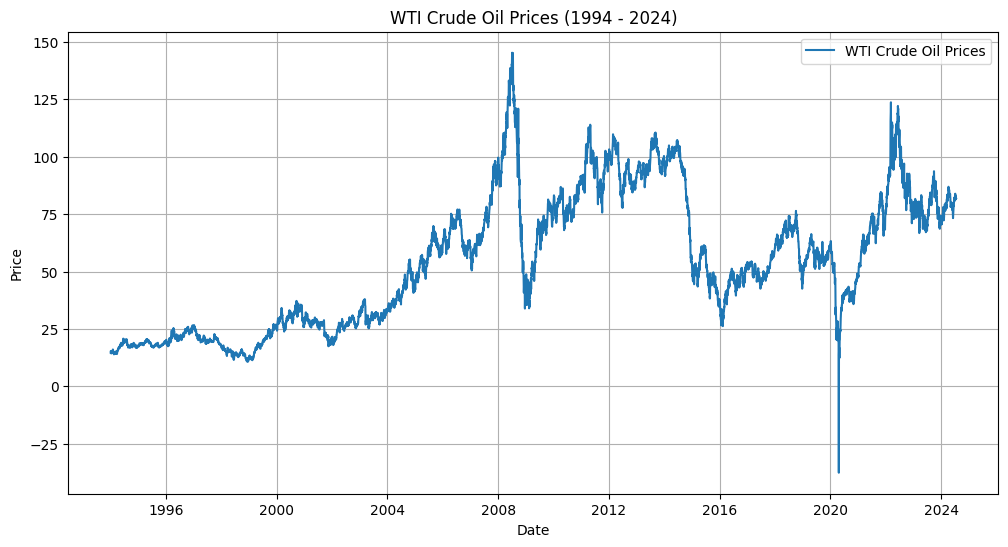

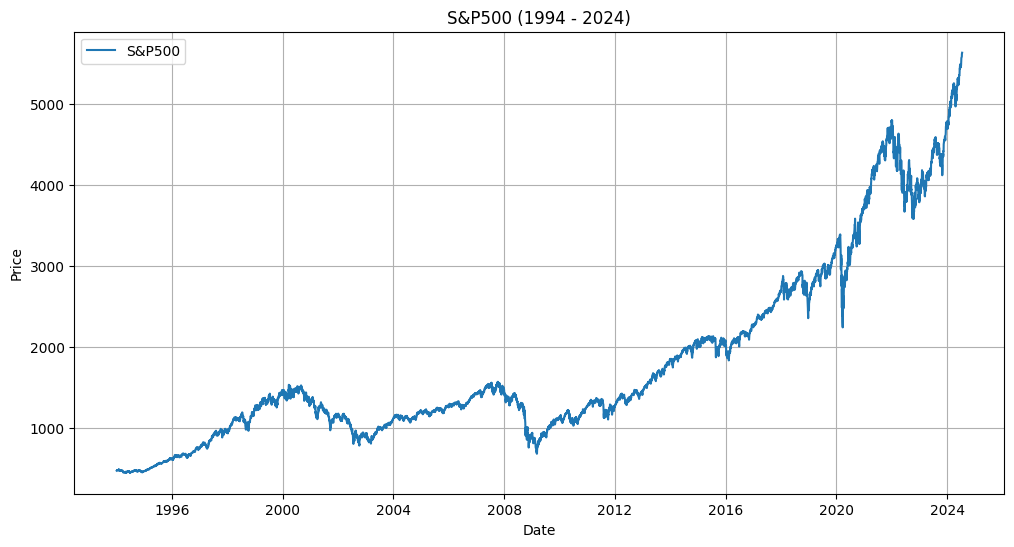

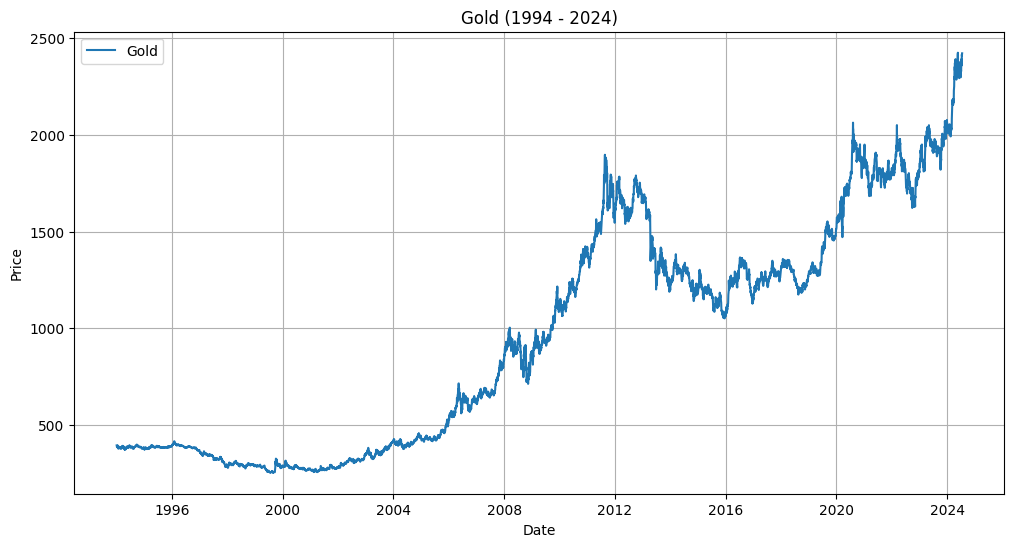

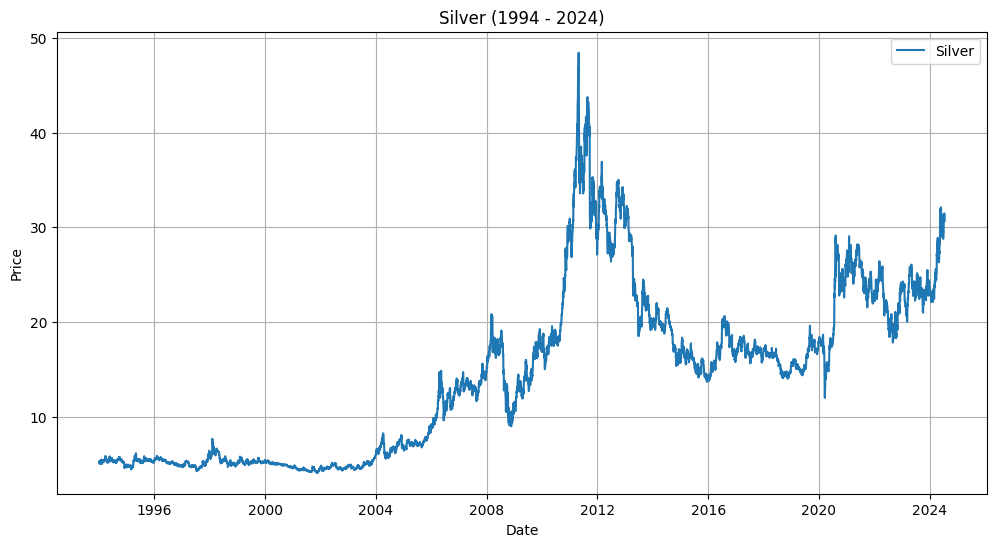

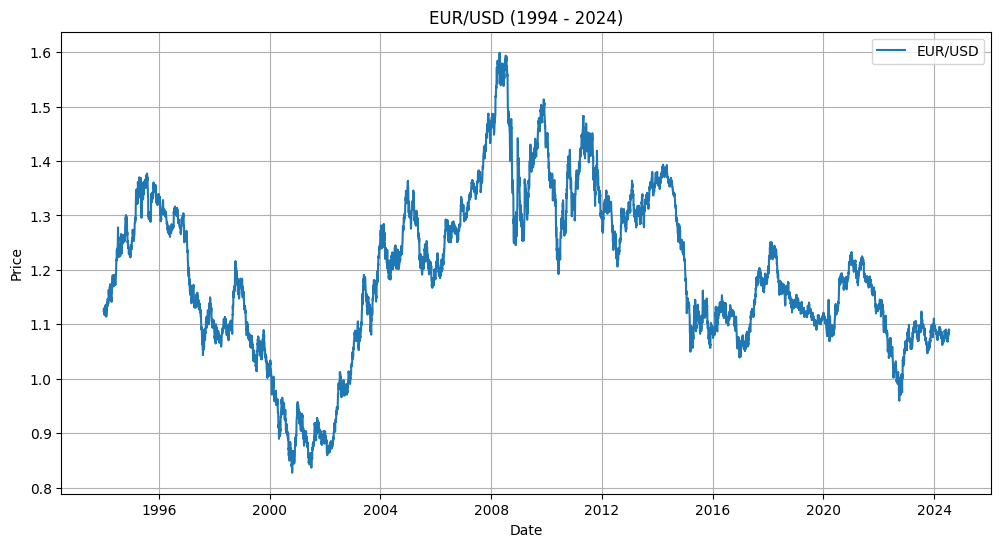

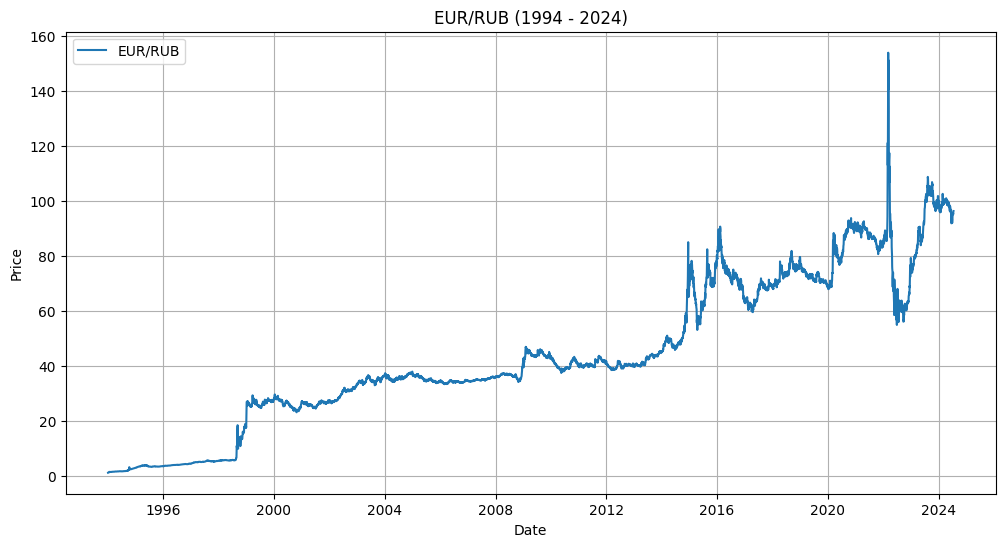

In [202]:
# Plotar gráficos para cada variável
variables = ['WTI Crude Oil Prices', 'S&P500', 'Gold', 'Silver', 'EUR/USD', 'EUR/RUB']
for var in variables:
    plot_variable(filtered_data, var)

## Describe das variáveis

In [203]:
# Descrever as variáveis
description = combined_data.describe()
print(tabulate(description, headers='keys', tablefmt='psql'))

+-------+------------------------+----------+----------+------------+-------------+-----------+
|       |   WTI Crude Oil Prices |   S&P500 |     Gold |     Silver |     EUR/USD |   EUR/RUB |
|-------+------------------------+----------+----------+------------+-------------+-----------|
| count |              7639      |  7639    | 7639     | 7639       | 7639        | 7639      |
| mean  |                54.8555 |  1806.76 |  961.095 |   14.2966  |    1.19128  |   44.1691 |
| std   |                29.0853 |  1144.45 |  587.185 |    8.81271 |    0.148147 |   26.8482 |
| min   |               -37.63   |   441.49 |  252.55  |    4.06    |    0.8272   |    1.1088 |
| 25%   |                27.585  |  1092.2  |  382.5   |    5.32    |    1.0916   |   27.3287 |
| 50%   |                53.01   |  1344.78 |  944     |   14.5     |    1.1815   |   38.9688 |
| 75%   |                77.475  |  2208.47 | 1370.28  |   19.6391  |    1.30285  |   68.7597 |
| max   |               145.29   |  5631

## Matriz de Correlação (Heatmap)

In [204]:
# Calcular a matriz de correlação
correlation_matrix = combined_data.corr()

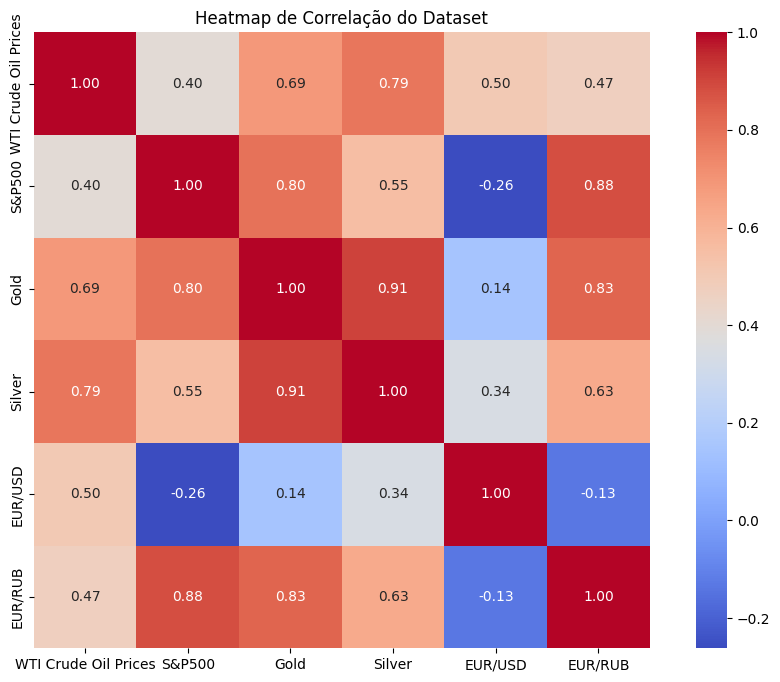

In [205]:
# Plotar o heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Heatmap de Correlação do Dataset')
plt.show()

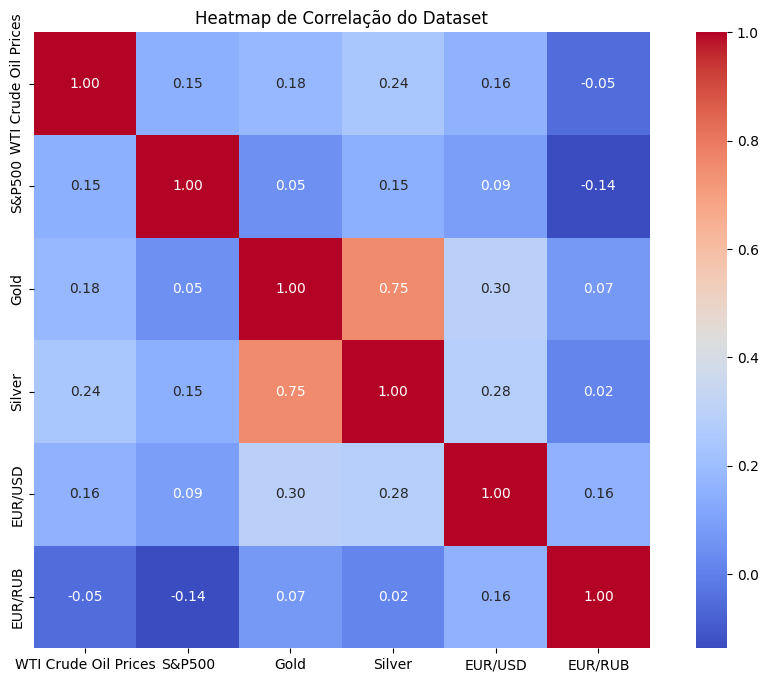

In [206]:
# Plotar o heatmap
correlation_matrix = dif_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Heatmap de Correlação do Dataset')
plt.show()

# Modelagem

## Creating Features and Target Variables

A variável a estudar é o WTI Crude Oil, com preços 1994 a 2024, e vamos definir um único horizonte
temporal, h=1 ou seja, prever o preço do WTI para o dia seguinte, usando um daily dataframe e uma window_size de 30 dias.

In [207]:
config = {
    "MAX_HORIZON": 15,
    "MAX_LAG": 30,
    "SCALER_TYPE": 'minmax',
    "target_col": 0,
    "models": [
        "Linear",
        "Ridge",
        # "Lasso",
        # "Elastic Net",
        # "Random Forest",
        # "XGBoost",
        # "SVR"
    ]
}

In [208]:
assert config["SCALER_TYPE"] in ['minmax', 'standard'], 'Invalid scaler type'

In [209]:
# Escalar os dados
if config["SCALER_TYPE"] == 'minmax':
    X_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
elif config["SCALER_TYPE"] == 'standard':
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
else:
    raise ValueError('Invalid scaler type')

#scaled_data = X_scaler.fit_transform(filtered_data)
#scaled_y = y_scaler.fit_transform(filtered_data['WTI Crude Oil Prices'].values.reshape(-1, 1))

## Train-Test Split

In [219]:
train_df

WTI Crude Oil Prices   S&P500     Gold   Silver  EUR/USD  EUR/RUB
Date                                                                         
1994-01-04                 14.67   466.89   393.85   5.2400   1.1246   1.1088
1994-01-05                 15.34   467.55   391.20   5.0900   1.1252   1.1154
1994-01-06                 15.42   467.12   388.90   5.1200   1.1252   1.1189
1994-01-07                 15.32   469.90   387.10   5.0100   1.1293   1.1148
1994-01-10                 14.67   475.27   384.60   5.0400   1.1269   1.1305
...                          ...      ...      ...      ...      ...      ...
2018-12-24                 42.53  2351.10  1269.22  14.7750   1.1406  78.2426
2018-12-26                 46.22  2467.70  1267.14  15.0355   1.1353  78.0339
2018-12-27                 44.61  2488.83  1275.71  15.2275   1.1430  79.4554
2018-12-28                 45.33  2485.74  1280.71  15.3839   1.1444  79.2991
2018-12-31                 45.41  2506.85  1282.49  15.4950   1.1467  79.4896

[6250 rows x 6 columns]

In [222]:
src_df = filtered_data

train_df = src_df.loc[:"2019-01-01"]
test_df = src_df.loc["2019-01-01":]

#scaled_data = X_scaler.fit_transform(filtered_data)
#scaled_y = y_scaler.fit_transform(filtered_data['WTI Crude Oil Prices'].values.reshape(-1, 1))

train_df_enc = pd.DataFrame(data=X_scaler.fit_transform(train_df), columns=train_df.columns, index=train_df.index)
train_df_enc.iloc[:,config["target_col"]] = y_scaler.fit_transform(train_df.iloc[:,config["target_col"]].values.reshape(-1, 1))


test_df_enc = pd.DataFrame(data=X_scaler.transform(test_df), columns=test_df.columns, index=test_df.index)
test_df_enc.iloc[:,config["target_col"]] = y_scaler.transform(test_df.iloc[:,config["target_col"]].values.reshape(-1, 1))


# scaled

Xha, yha, Ha = create_features_and_targets(train_df_enc, config["MAX_HORIZON"], config["MAX_LAG"],  config["target_col"])
Xht, yht, Ht = create_features_and_targets(test_df_enc, config["MAX_HORIZON"], config["MAX_LAG"],  config["target_col"])

/tmp/ipykernel_31623/1683036646.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[[0.02935275]
 [0.03433157]
 [0.03492606]
 ...
 [0.25183919]
 [0.25718957]
 [0.25778405]]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  train_df_enc.iloc[:,config["target_col"]] = y_scaler.fit_transform(train_df.iloc[:,config["target_col"]].values.reshape(-1, 1))
/tmp/ipykernel_31623/1683036646.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[[0.26618117]
 [0.27026826]
 [0.2767333 ]
 ...
 [0.53429442]
 [0.53124768]
 [0.52901835]]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test_df_enc.iloc[:,config["target_col"]] = y_scaler.transform(test_df.iloc[:,config["target_col"]].values.reshape(-1, 1))


In [181]:
# for each month, select the 2nd to last wednesday
filtered_data['year'] = filtered_data.index.year
filtered_data['month'] = filtered_data.index.month
filtered_data['day'] = filtered_data.index.day

filtered_data['Monthly Average'] = filtered_data['WTI Crude Oil Prices'].resample('ME').transform('mean')
filtered_data['Monthly Average'] = filtered_data['Monthly Average'].ffill()


wed_mask = filtered_data.index.weekday == 2
test_mask = (filtered_data.index > '2020-01-01') & (filtered_data.index < '2024-06-01') & wed_mask

filtered_data[test_mask].groupby(['year', 'month']).nth(-2)

WTI Crude Oil Prices   S&P500     Gold   Silver  EUR/USD  \
Date                                                                   
2020-01-22                 56.74  3321.75  1558.78  17.8397   1.1093   
2020-02-19                 53.29  3386.15  1611.70  18.4320   1.0805   
2020-03-18                 20.37  2398.10  1486.05  11.9810   1.0915   
2020-04-22                 13.78  2799.31  1714.08  15.0970   1.0823   
2020-05-20                 33.49  2971.61  1748.18  17.5567   1.0980   
2020-06-17                 37.96  3113.49  1726.95  17.5050   1.1244   
2020-07-22                 41.90  3276.02  1871.41  22.9960   1.1570   
2020-08-19                 42.93  3374.85  1928.98  26.7005   1.1838   
2020-09-23                 39.93  3236.92  1863.34  22.7784   1.1660   
2020-10-21                 40.03  3435.56  1924.33  25.0472   1.1861   
2020-11-18                 41.82  3567.79  1872.24  24.3365   1.1853   
2020-12-23                 48.12  3690.01  1872.89  25.5420   1.2187   
2021-01-20                 53.24  3851.85  1871.84  25.8425   1.2106   
2021-02-17                 61.14  3931.33  1776.13  27.3829   1.2038   
2021-03-24                 61.18  3889.14  1734.69  25.0948   1.1813   
2021-04-21                 61.35  4173.42  1793.79  26.5538   1.2035   
2021-05-19                 63.36  4115.68  1869.62  27.7366   1.2175   
2021-06-23                 73.08  4241.84  1778.68  25.8914   1.1926   
2021-07-21                 70.30  4358.69  1803.66  25.2612   1.1794   
2021-08-18                 65.46  4400.27  1787.82  23.5090   1.1711   
2021-09-22                 72.23  4395.64  1768.16  22.6963   1.1687   
2021-10-20                 83.87  4536.19  1782.08  24.2920   1.1651   
2021-11-17                 78.36  4688.67  1867.48  25.0858   1.1319   
2021-12-22                 72.76  4696.56  1803.67  22.8110   1.1326   
2022-01-19                 86.96  4532.76  1840.54  24.1385   1.1343   
2022-02-16                 93.66  4475.01  1869.80  23.5975   1.1373   
2022-03-23                114.93  4456.24  1943.86  25.1110   1.1004   
2022-04-20                102.75  4459.45  1957.77  25.2045   1.0853   
2022-05-18                109.59  3923.68  1816.60  21.4230   1.0464   
2022-06-22                106.19  3759.89  1837.72  21.4187   1.0566   
2022-07-20                102.26  3959.90  1696.58  18.6789   1.0180   
2022-08-24                 94.89  4140.77  1751.19  19.1125   0.9967   
2022-09-21                 82.94  3789.93  1673.89  19.5684   0.9837   
2022-10-19                 85.55  3695.16  1629.44  18.4638   0.9773   
2022-11-23                 77.94  4027.26  1749.68  21.5380   1.0397   
2022-12-21                 78.29  3878.44  1814.39  23.9655   1.0605   
2023-01-18                 79.48  3928.86  1904.11  23.4645   1.0794   
2023-02-15                 78.59  4147.60  1836.01  21.6264   1.0689   
2023-03-22                 70.90  3936.97  1970.11  22.9896   1.0856   
2023-04-19                 79.16  4154.52  1994.93  25.2915   1.0955   
2023-05-24                 74.34  4115.24  1957.16  23.0560   1.0750   
2023-06-21                 72.53  4365.69  1932.55  22.6364   1.0986   
2023-07-19                 75.35  4565.72  1976.64  25.1452   1.1201   
2023-08-23                 78.89  4436.01  1915.48  24.3108   1.0863   
2023-09-20                 90.28  4402.20  1930.30  23.2387   1.0661   
2023-10-18                 88.32  4314.60  1947.55  22.8415   1.0536   
2023-11-22                 77.10  4556.62  1990.17  23.6316   1.0888   
2023-12-20                 74.22  4698.35  2031.39  24.1473   1.0942   
2024-01-24                 75.09  4868.55  2013.89  22.6675   1.0885   
2024-02-21                 77.91  4981.80  2025.99  22.8860   1.0819   
2024-03-20                 81.68  5224.62  2186.39  25.5824   1.0922   
2024-04-17                 82.69  5022.21  2361.02  28.2233   1.0673   
2024-05-22                 77.57  5307.01  2378.85  30.7902   1.0823   

             EUR/RUB  year  month  day  Monthly Ave

In [226]:
assert Xha.shape[1] == Xht.shape[1], 'Erro no número de amostras de treino'

No train-test split usou-se um rácio de 80/20

In [227]:
# Função para dividir os dados em treino e teste com um ratio de 80/20
def split_data(X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)
    return X_train, X_test, y_train, y_test

In [302]:
# Treinar e avaliar os modelos
valid_models = {
    "Linear": {
        "callable": LinearRegression,
        "params": {},
        },
    "Ridge": {
        "callable": Ridge,
        "params": {"alpha": 0.01},
        },
    "Lasso": {
        "callable": Lasso,
        "params": {"alpha": 0.01},
        },
    "Elastic Net": {
        "callable": ElasticNet,
        "params": {"alpha": 0.01, "l1_ratio": 0.5},
        },
    "Random Forest": {
        "callable": RandomForestRegressor,
        "params": {},
        },
    "XGBoost": {
        "callable": XGBRegressor,
        "params": {},
        },
    "SVR": {
        "callable": SVR,
        "params": {"kernel": 'rbf'},
        }
}

# check that all models in config are valid
assert all(model in valid_models for model in config["models"]), 'Invalid models in config'

# filter models based on config
models = {k: v for k, v in valid_models.items() if k in config["models"]}

## Métricas usadas (RMSE, MAPE, R^2 e MSE)

In [304]:
results = {horizon: {name: {} for name in models.keys()} for horizon in yha.keys()}
results2 = []

for horizon in results.keys():
    X_train = Xha
    X_test = Xht
    y_train = yha[horizon]
    y_test = yht[horizon]
    #X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2)

    y_test_descaled = y_scaler.inverse_transform(y_test.reshape(-1,1))

    for name, mdict in models.items():
        model = mdict["callable"](**mdict["params"])
        trained_model = model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        y_pred = y_scaler.inverse_transform(y_pred.reshape(-1,1))

        rmse = root_mean_squared_error(y_test_descaled, y_pred)
        mse = mean_squared_error(y_test_descaled, y_pred)
        mape = mean_absolute_percentage_error(y_test_descaled, y_pred)
        r2 = r2_score(y_test_descaled, y_pred)
        results[horizon][name] = {
            "horizon": horizon,
            "name": name,
            "model": model,
            "RMSE": rmse,
            "MSE": mse,
            "MAPE": mape,
            "R2": r2,
            "y_pred": y_pred,
        }
        results2.append({
            "horizon": horizon,
            "name": name,
            "model": model,
            "RMSE": rmse,
            "MSE": mse,
            "MAPE": mape,
            "R2": r2,
            "y_pred": y_pred,
        })

# specifiy every model, add a key is_best if that model is the best in that horizon
for horizon in results.keys():
    best_model = min(results[horizon].keys(), key=lambda x: results[horizon][x]["RMSE"])
    results[horizon][best_model]["is_best"] = True

# Modelos de Machine Learning

## Resultados

Inicialmente foram usados 4 modelos (Linear, Ridge, Lasso e Elastic Net Regressions) para testar o daily dataframe com h=1. Seguidamente, foram adicionados o Random Forest, XGBoost e o SVR com a RBF de Kernel.

In [244]:
res_df = pd.DataFrame(results2)
res_df.drop(columns=['model', "y_pred"], inplace=True)
res_df

horizon    name      RMSE        MSE      MAPE        R2
0         0  Linear  2.773029   7.689689  0.027527  0.980942
1         0   Ridge  2.751197   7.569088  0.027419  0.981241
2         1  Linear  3.452408  11.919121  0.036421  0.970458
3         1   Ridge  3.331496  11.098867  0.035252  0.972491
4         2  Linear  3.914013  15.319496  0.042687  0.962030
5         2   Ridge  3.768987  14.205262  0.041234  0.964791
6         3  Linear  4.313219  18.603859  0.046757  0.953888
7         3   Ridge  4.135969  17.106242  0.046094  0.957600
8         4  Linear  4.661536  21.729922  0.051804  0.946142
9         4   Ridge  4.466553  19.950096  0.050462  0.950553
10        5  Linear  4.967640  24.677445  0.056512  0.938840
11        5   Ridge  4.756874  22.627851  0.054690  0.943920
12        6  Linear  5.220741  27.256139  0.059696  0.932453
13        6   Ridge  5.017506  25.175363  0.058731  0.937610
14        7  Linear  5.426989  29.452215  0.063490  0.927017
15        7   Ridge  5.269996  27.772859  0.062610  0.931178
16        8  Linear  5.691907  32.397800  0.066542  0.919721
17        8   Ridge  5.512811  30.391086  0.066030  0.924694
18        9  Linear  5.928154  35.143010  0.069994  0.912934
19        9   Ridge  5.732029  32.856152  0.069163  0.918599
20       10  Linear  6.105374  37.275588  0.073466  0.907663
21       10   Ridge  5.931264  35.179889  0.072194  0.912854
22       11  Linear  6.283927  39.487744  0.075759  0.902186
23       11   Ridge  6.140540  37.706231  0.074760  0.906599
24       12  Linear  6.502159  42.278068  0.077869  0.895277
25       12   Ridge  6.386387  40.785937  0.077206  0.898973
26       13  Linear  6.793977  46.158119  0.080620  0.885674
27       13   Ridge  6.652750  44.259081  0.079718  0.890378
28       14  Linear  7.042415  49.595603  0.083763  0.877165
29       14   Ridge  6.920154  47.888537  0.082732  0.881393
30       15  Linear  7.335512  53.809732  0.087263  0.866733
31       15   Ridge  7.203035  51.883712  0.085974  0.871503

## Tabelas c/ modelos, horizontes e métricas

# Previsões

In [253]:
# Função para plotar previsões vs valores reais com valores desescalados
def plot_predictions(y_test, y_pred, model_name, horizon, x_axis=None):
    # y_test_descaled = inverse_transform(y_scaler, np.zeros((y_test.shape[0], scaled_data.shape[1] - 1)), y_test)
    # y_pred_descaled = inverse_transform(y_scaler, np.zeros((y_pred.shape[0], scaled_data.shape[1] - 1)), y_pred)
    
    plt.figure(figsize=(12, 6))
    if x_axis is None:
        x_axis = range(len(y_test))
    plt.plot(x_axis, y_test, label='True', color='blue')
    plt.plot(x_axis, y_pred, label=model_name, color='orange')
    plt.title(f'Predição do modelo {model_name} para horizonte de {horizon} dias')
    plt.xlabel('Observations')
    plt.ylabel('WTI Crude Oil Prices')
    plt.legend()
    plt.grid(True)
    plt.show()

Horizonte: 0 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


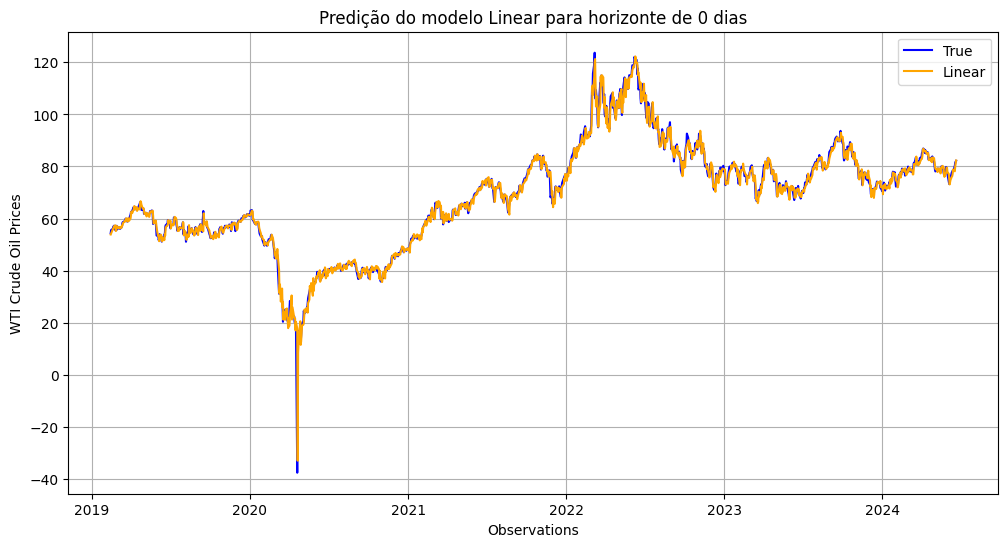

Modelo: Ridge - Tamanho de y_pred: 1344


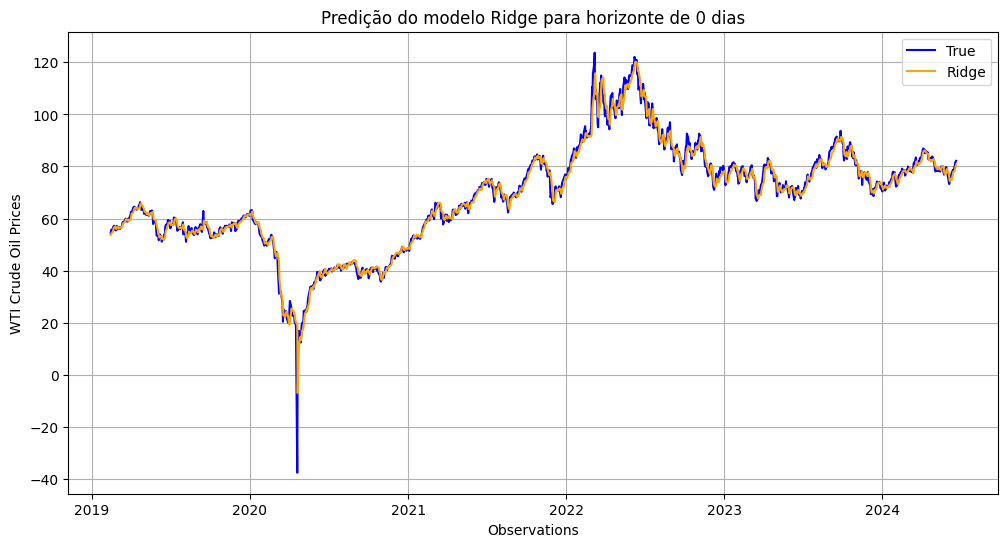

Horizonte: 1 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


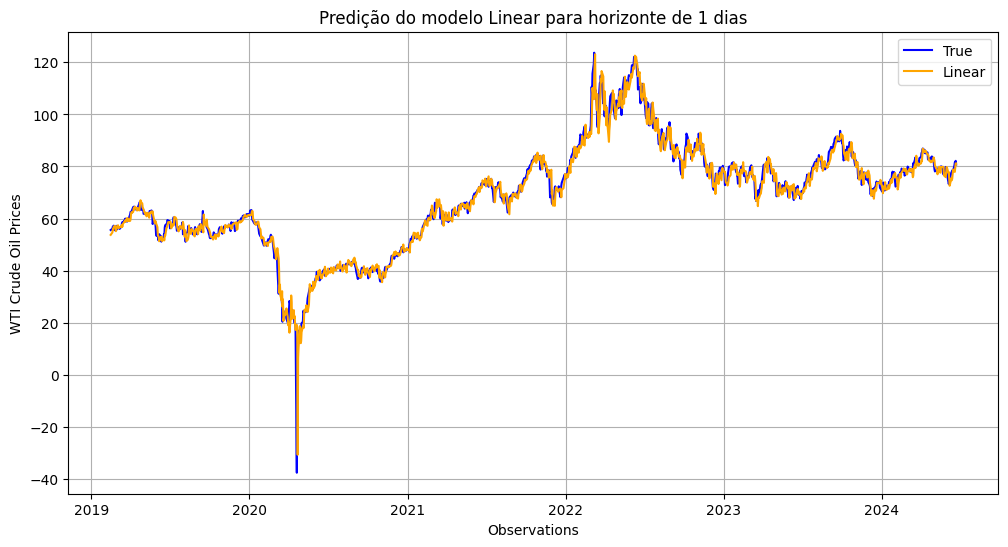

Modelo: Ridge - Tamanho de y_pred: 1344


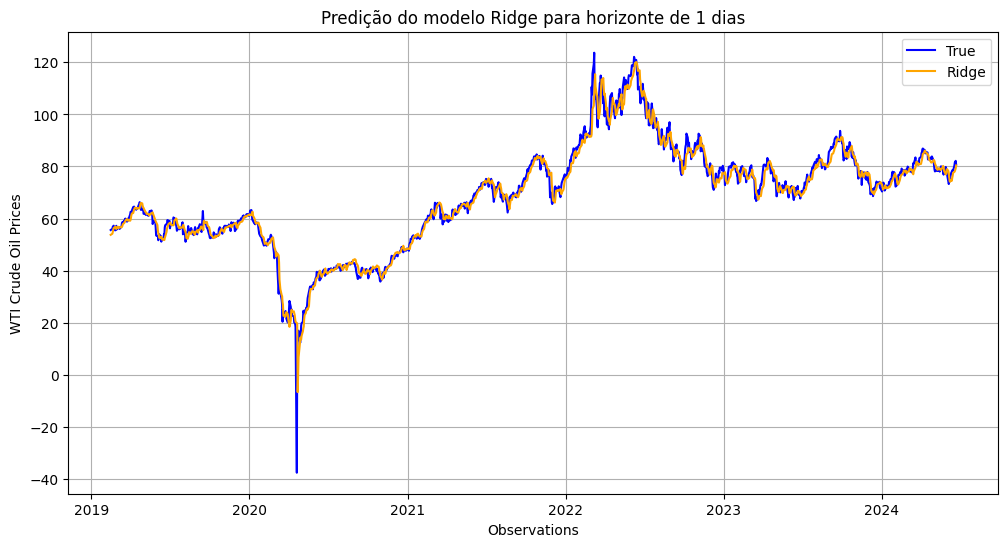

Horizonte: 2 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


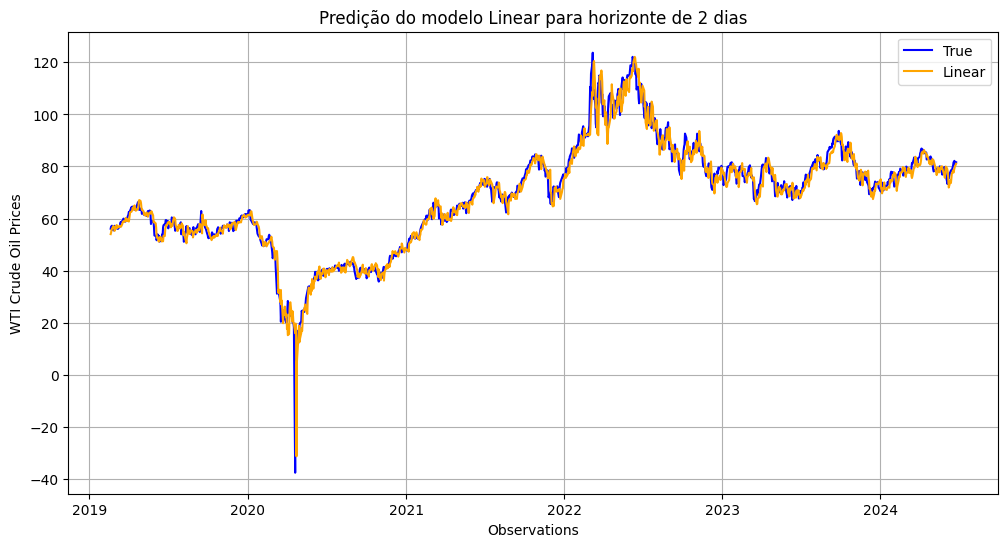

Modelo: Ridge - Tamanho de y_pred: 1344


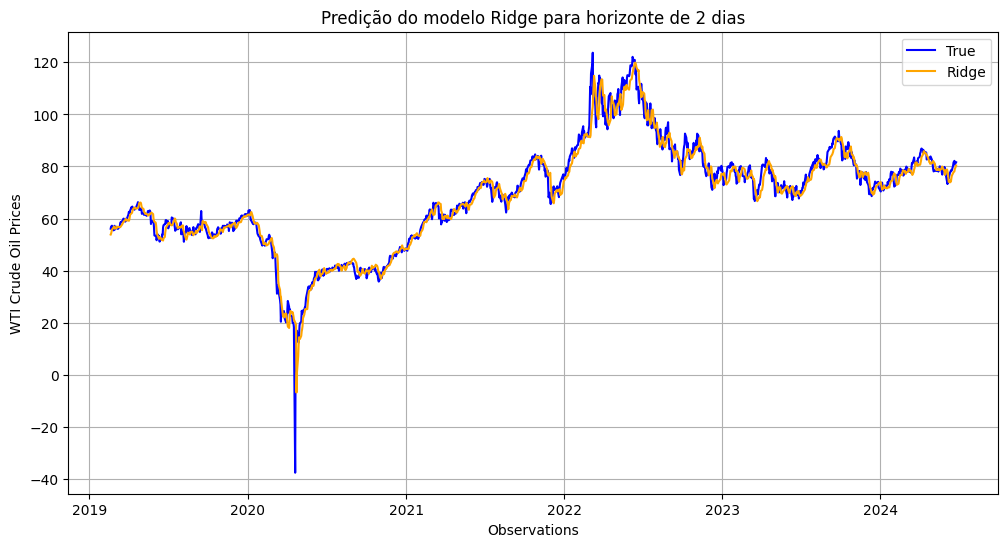

Horizonte: 3 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


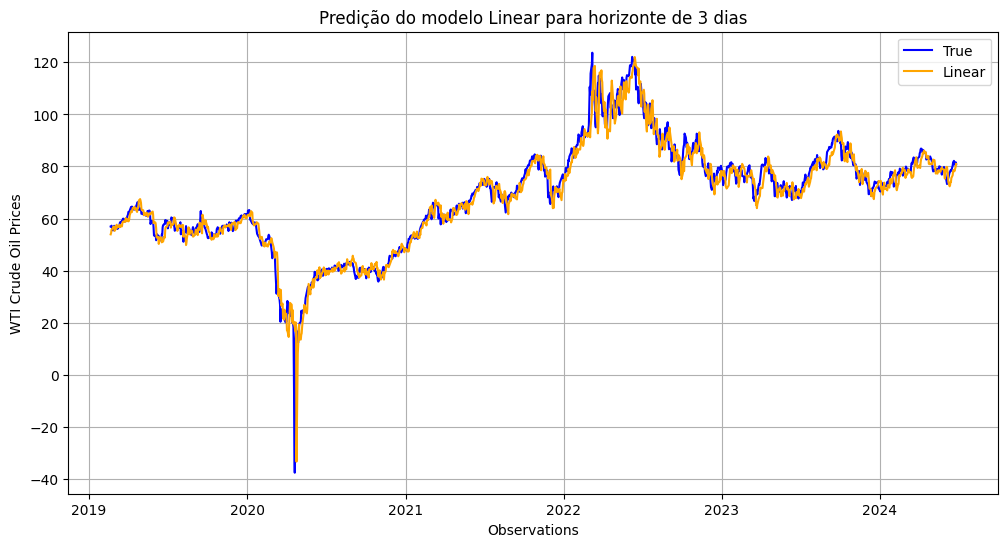

Modelo: Ridge - Tamanho de y_pred: 1344


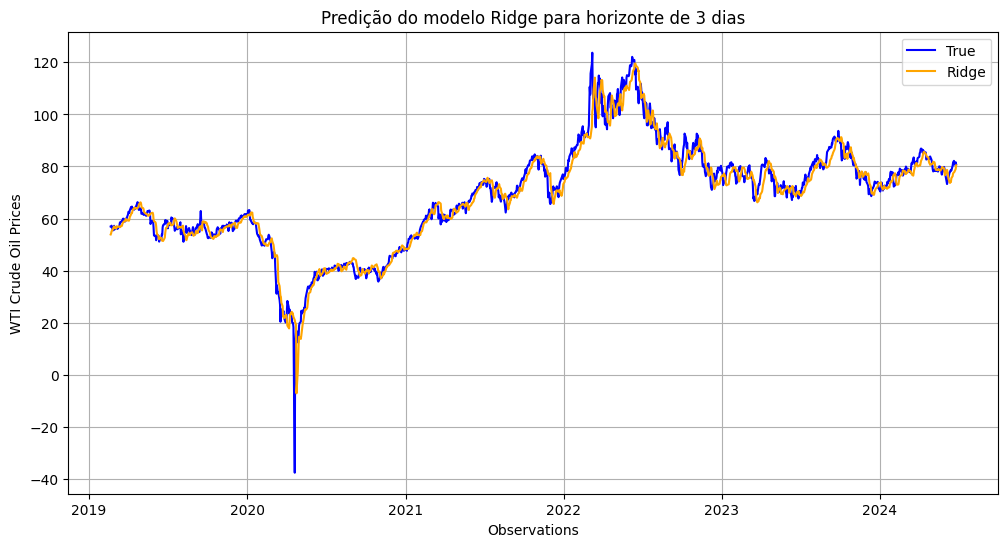

Horizonte: 4 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


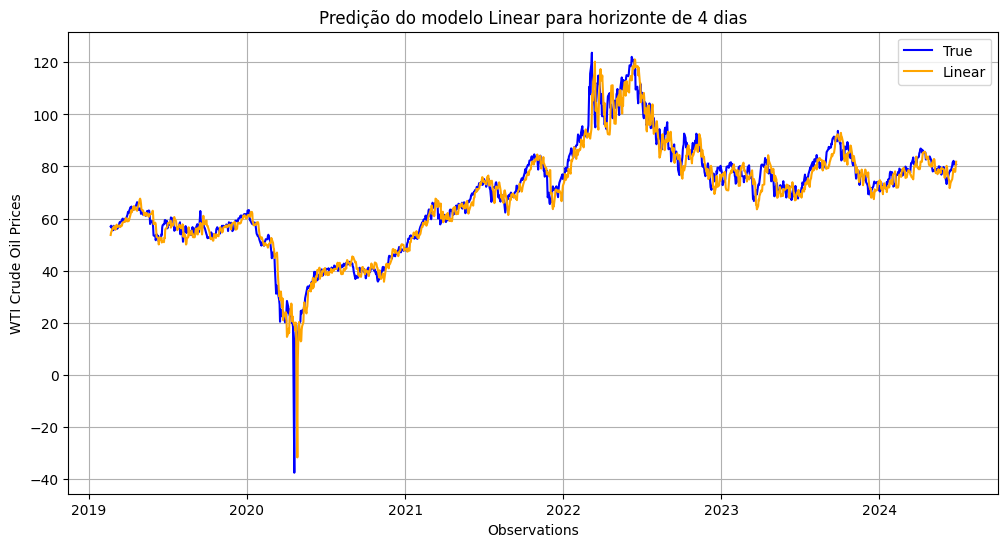

Modelo: Ridge - Tamanho de y_pred: 1344


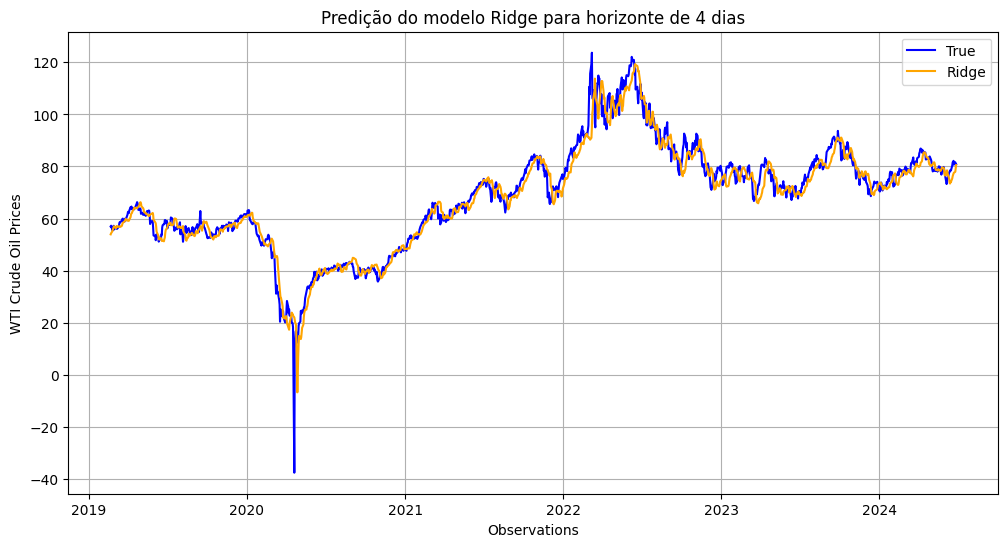

Horizonte: 5 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


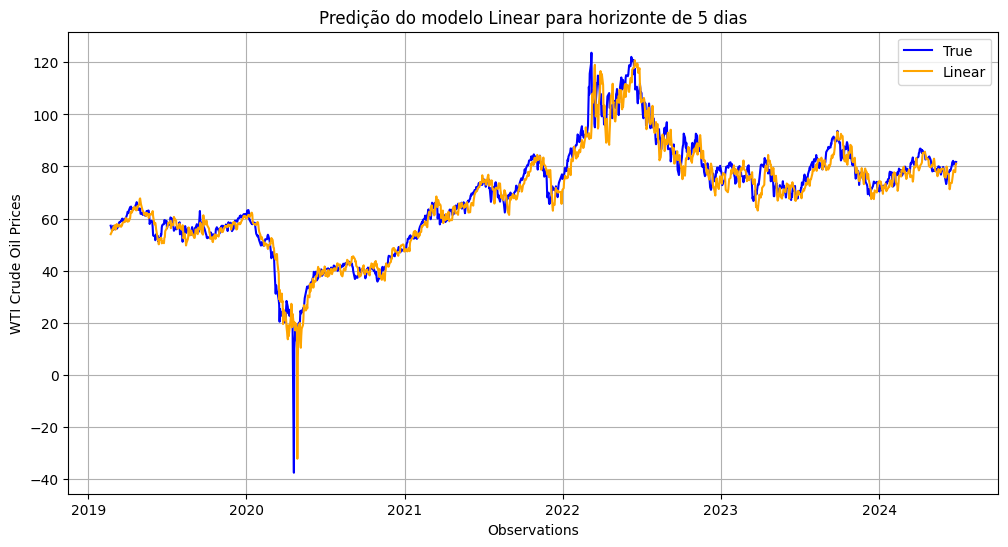

Modelo: Ridge - Tamanho de y_pred: 1344


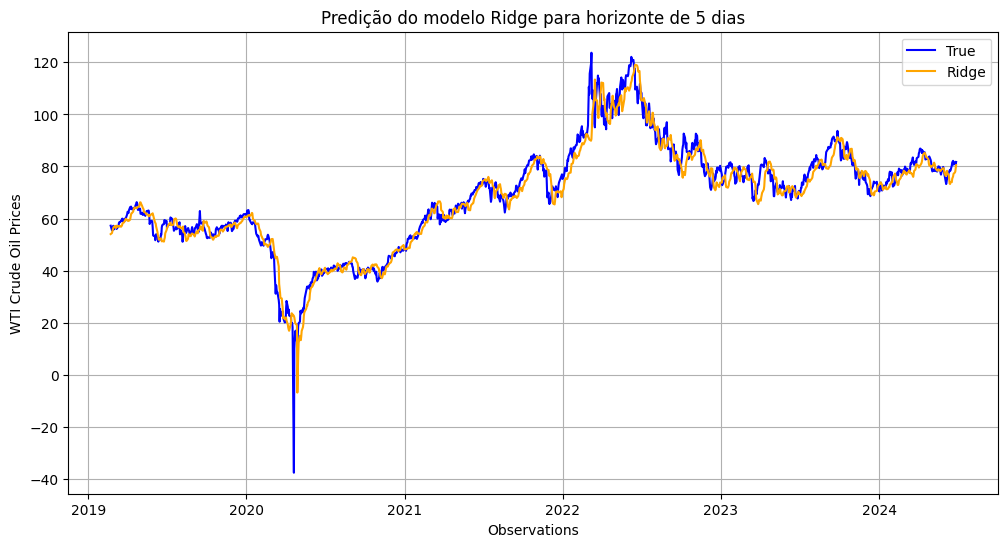

Horizonte: 6 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


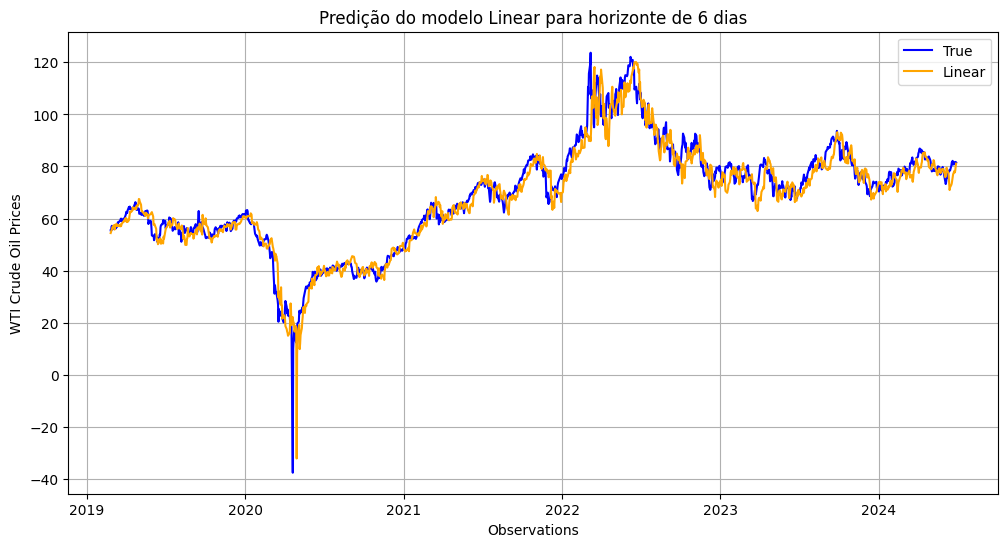

Modelo: Ridge - Tamanho de y_pred: 1344


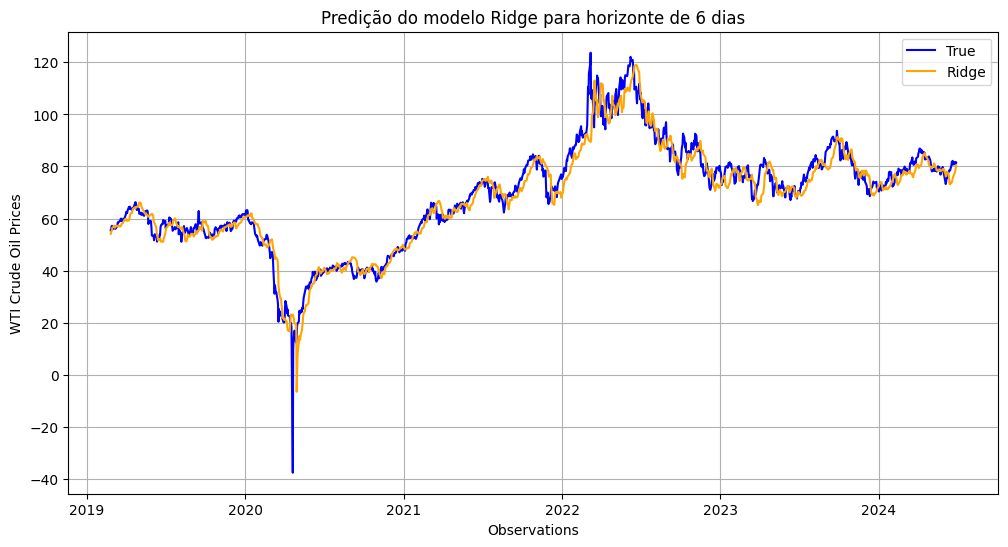

Horizonte: 7 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


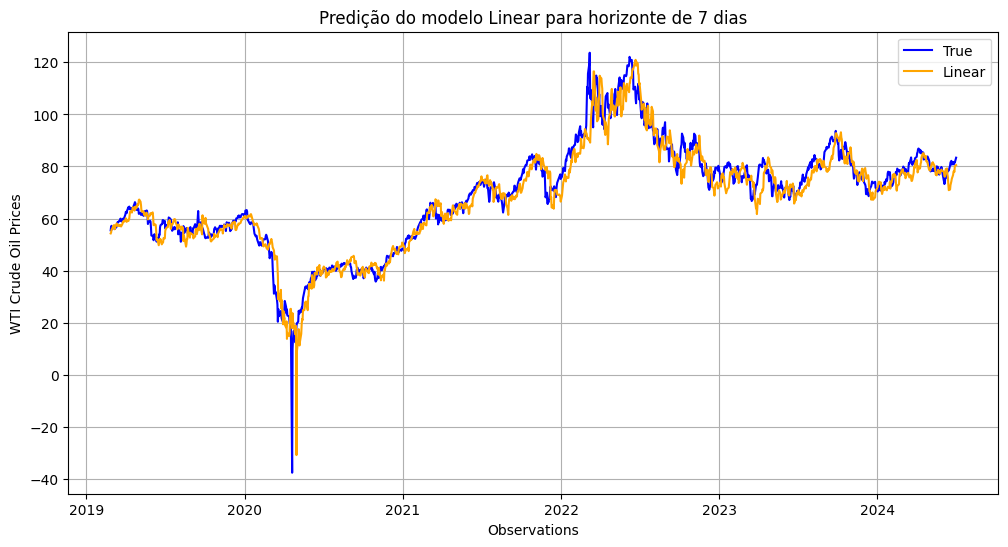

Modelo: Ridge - Tamanho de y_pred: 1344


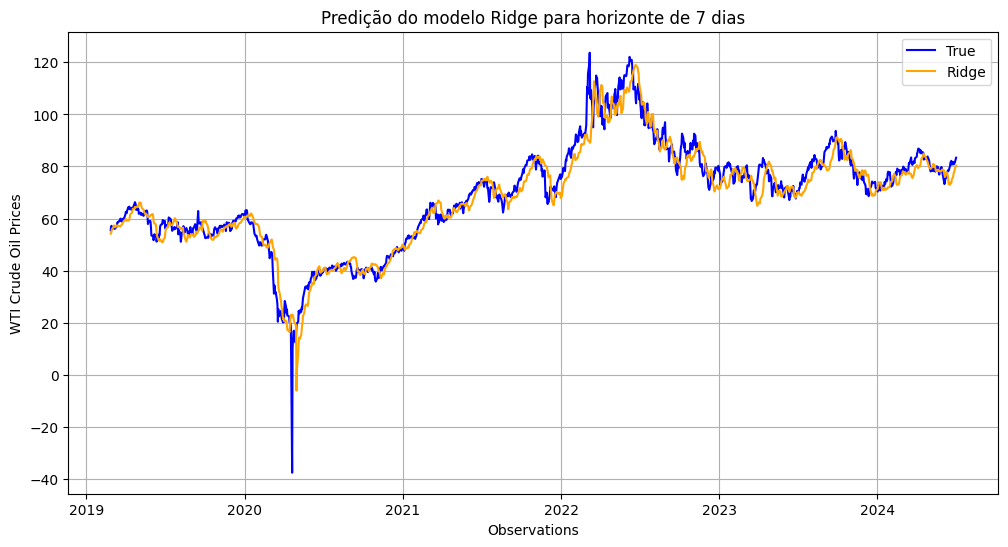

Horizonte: 8 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


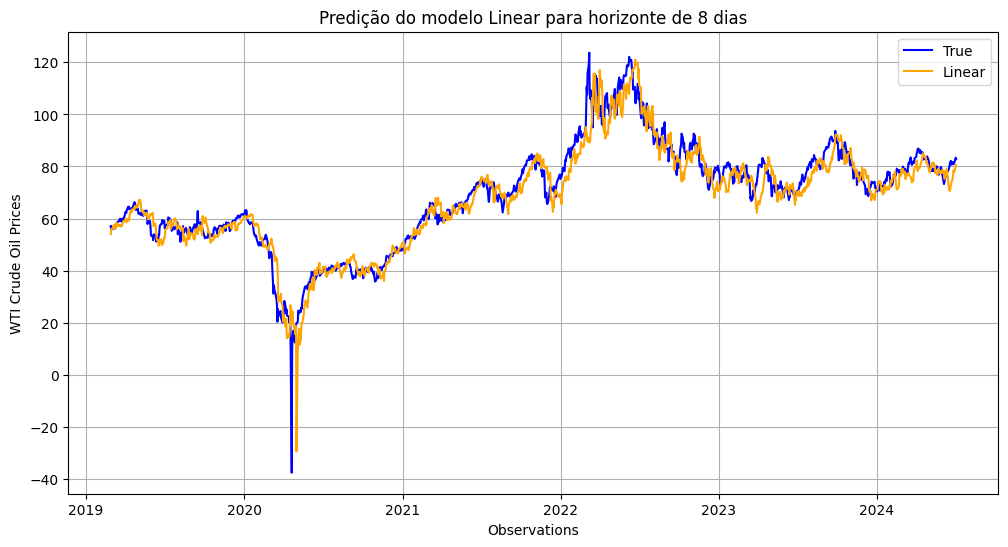

Modelo: Ridge - Tamanho de y_pred: 1344


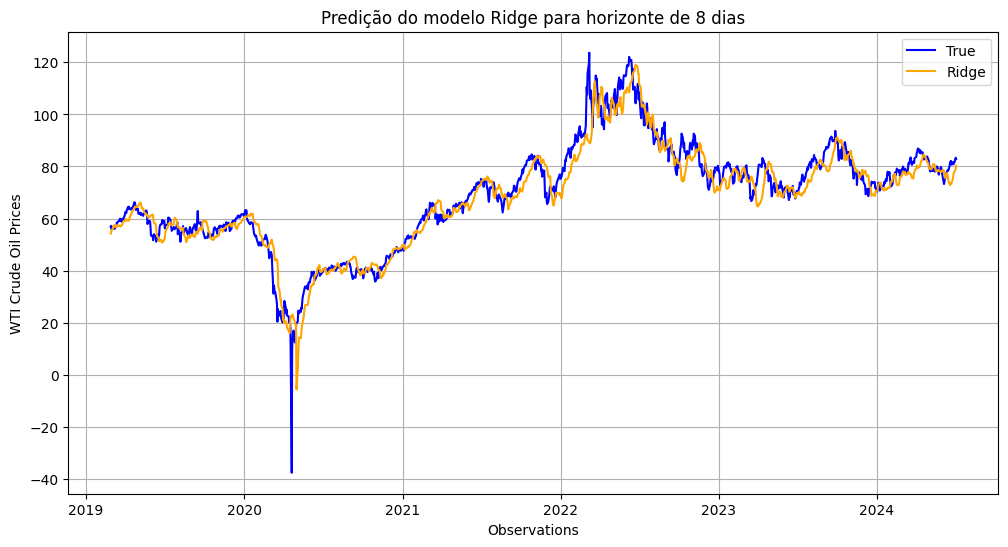

Horizonte: 9 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


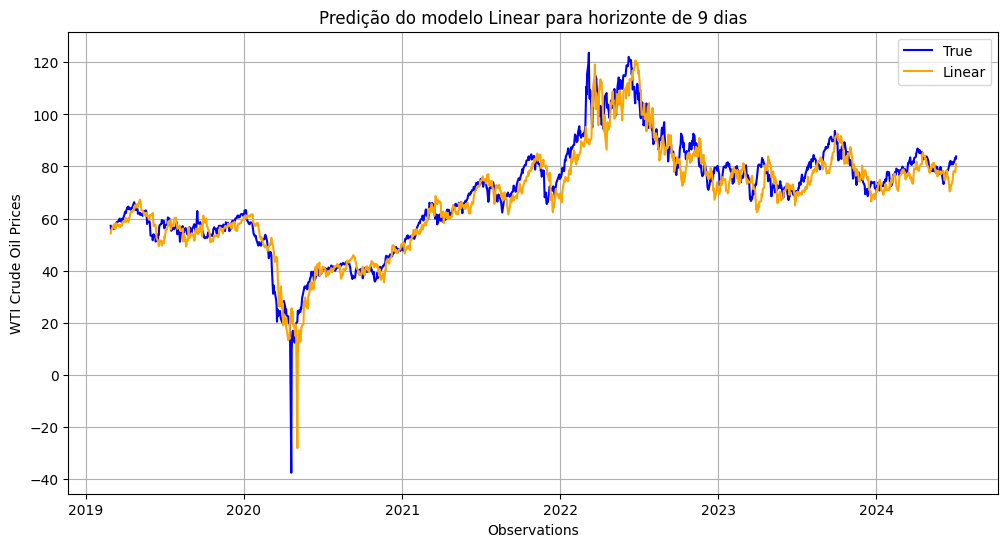

Modelo: Ridge - Tamanho de y_pred: 1344


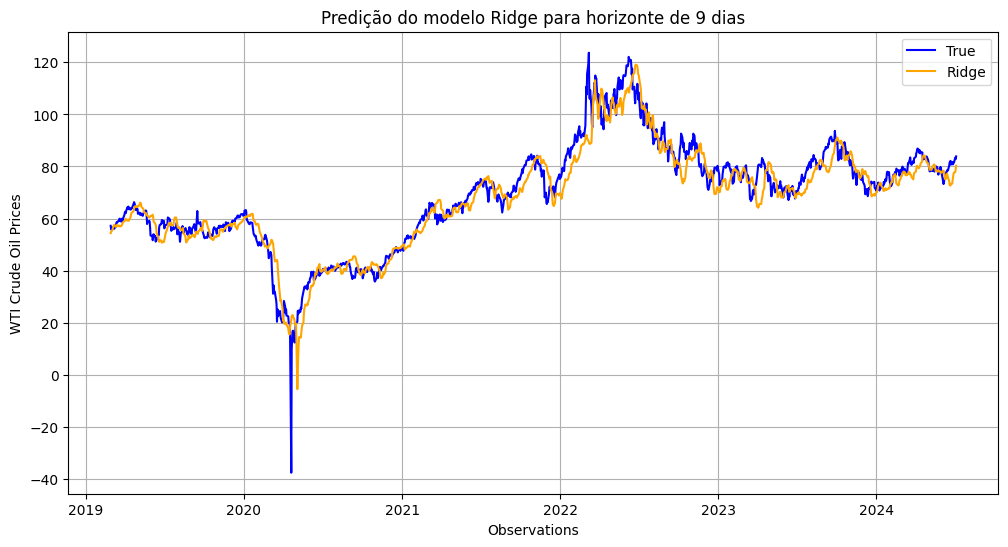

Horizonte: 10 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


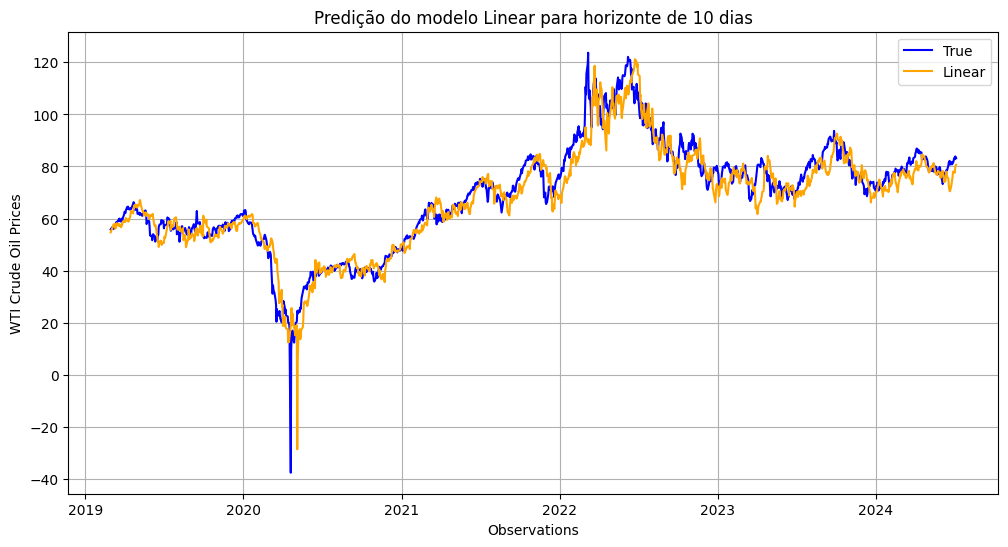

Modelo: Ridge - Tamanho de y_pred: 1344


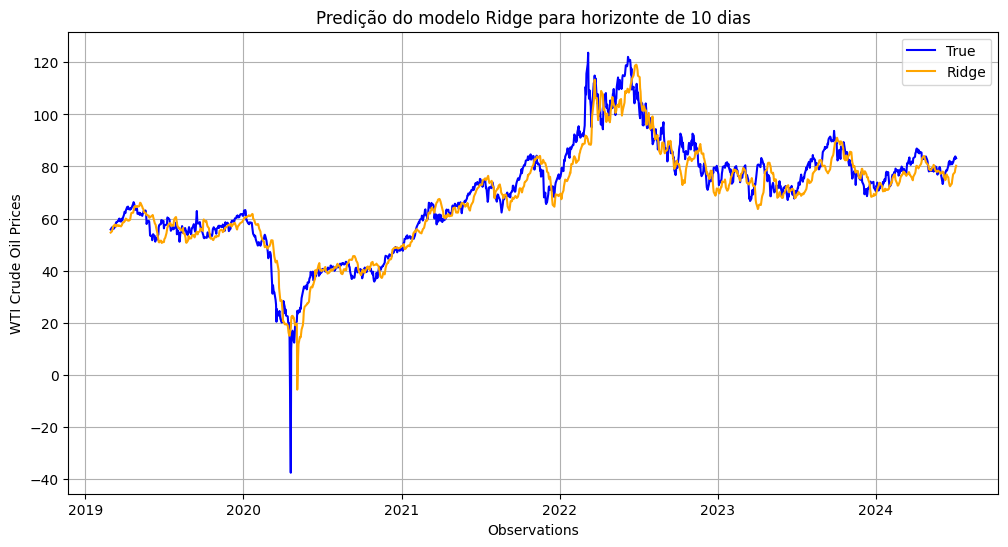

Horizonte: 11 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


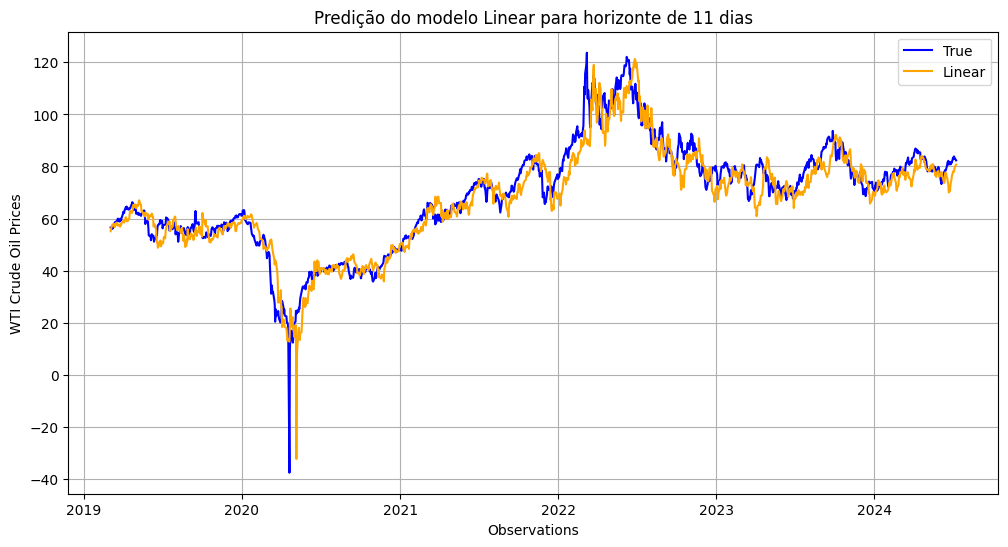

Modelo: Ridge - Tamanho de y_pred: 1344


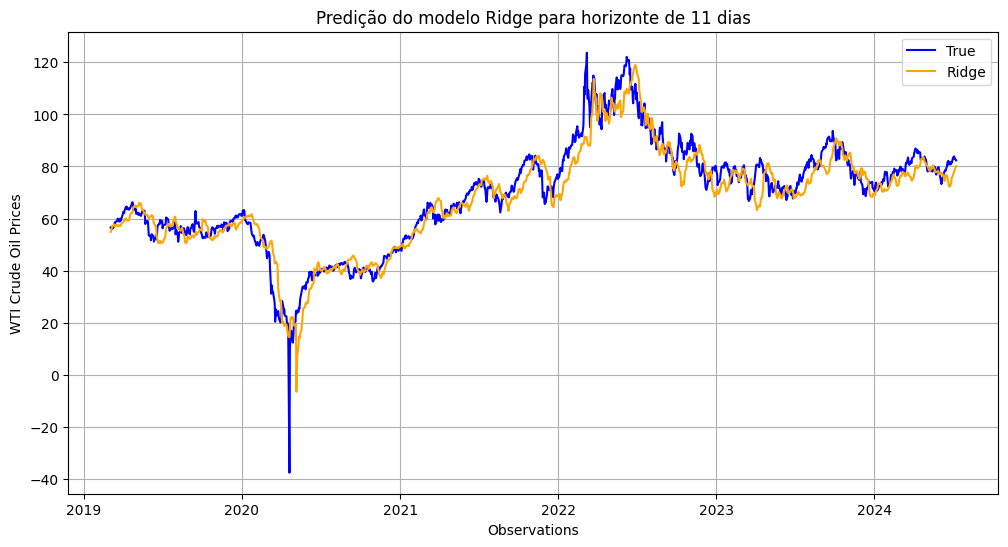

Horizonte: 12 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


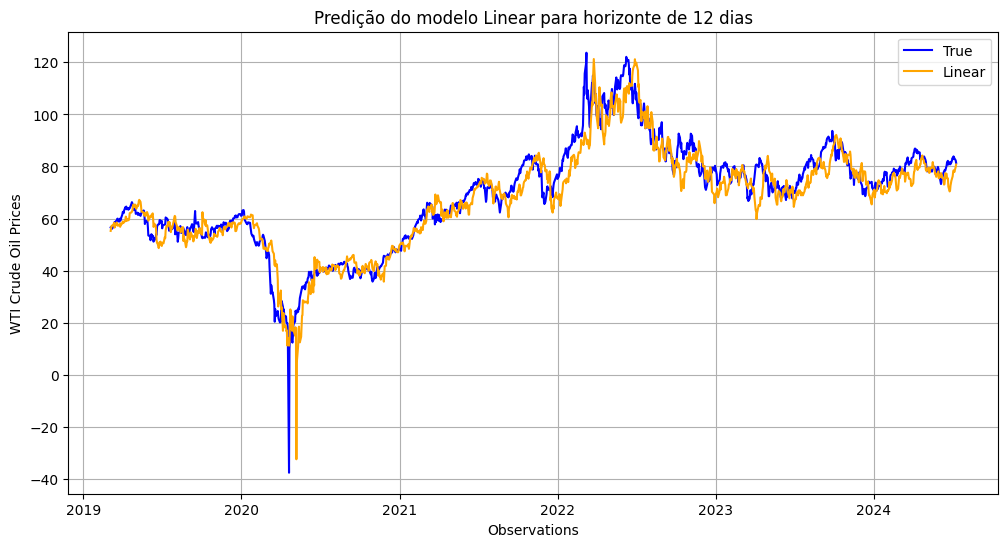

Modelo: Ridge - Tamanho de y_pred: 1344


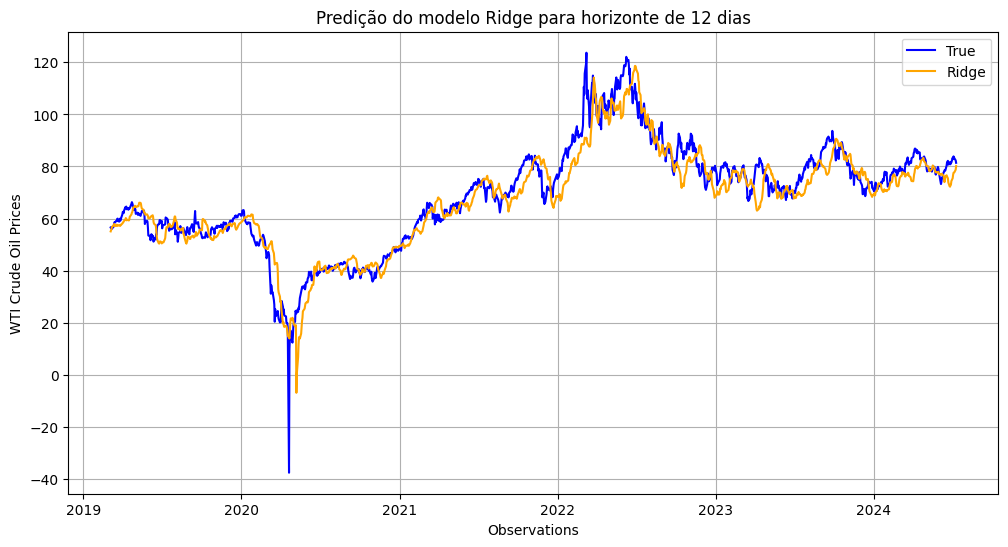

Horizonte: 13 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


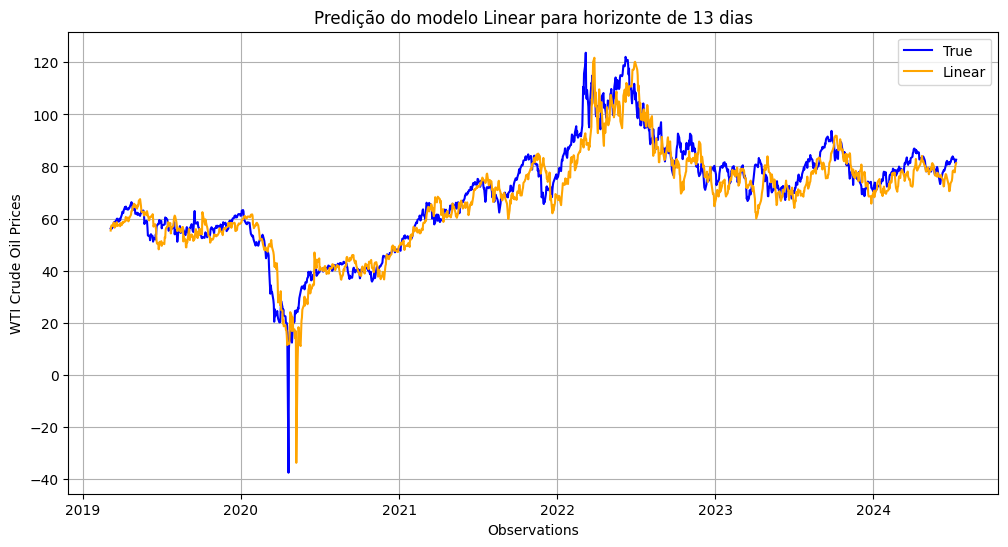

Modelo: Ridge - Tamanho de y_pred: 1344


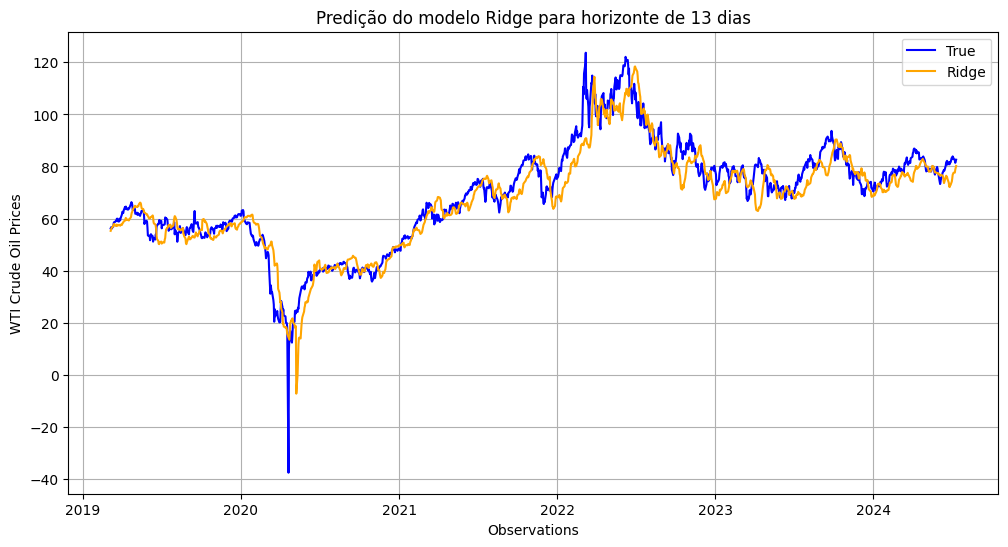

Horizonte: 14 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


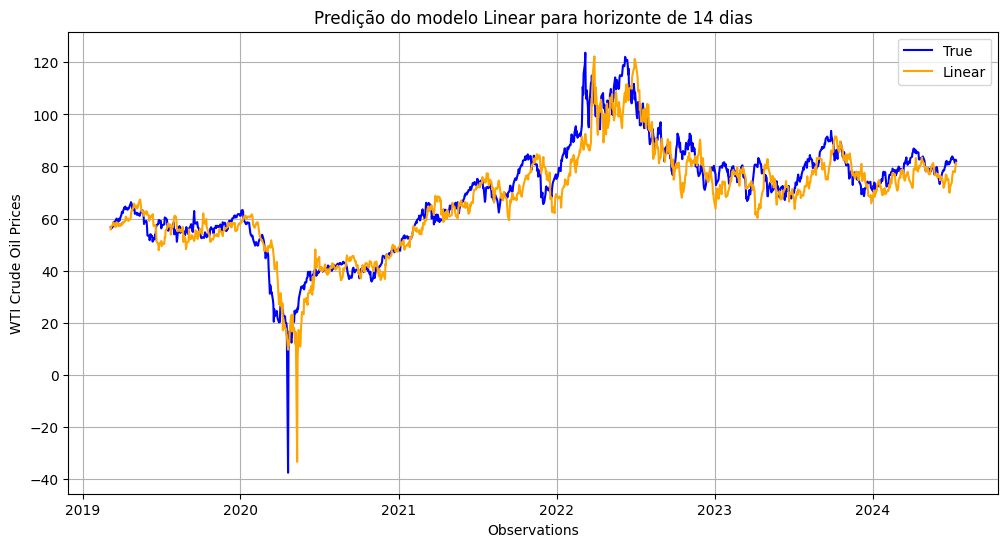

Modelo: Ridge - Tamanho de y_pred: 1344


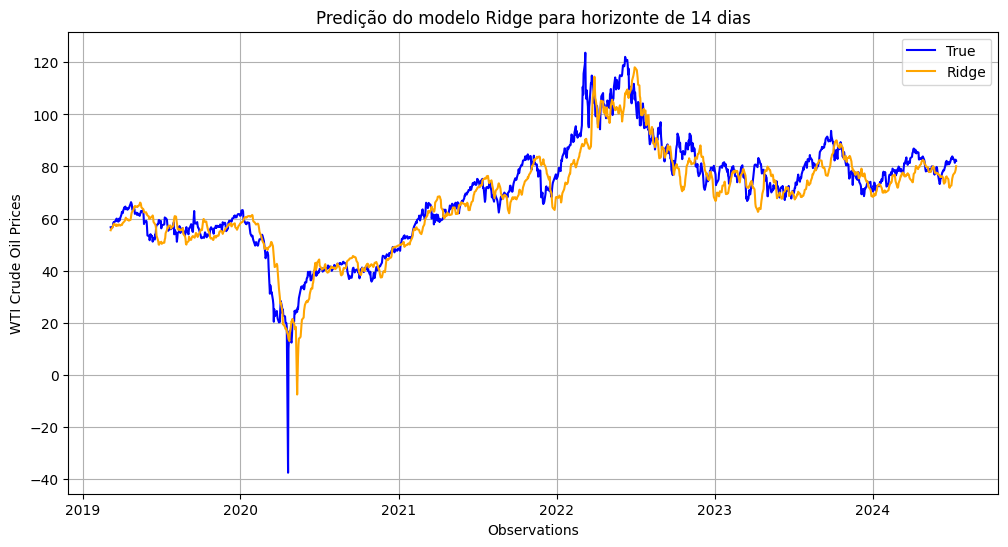

Horizonte: 15 - Tamanho de y_test: 1344
Modelo: Linear - Tamanho de y_pred: 1344


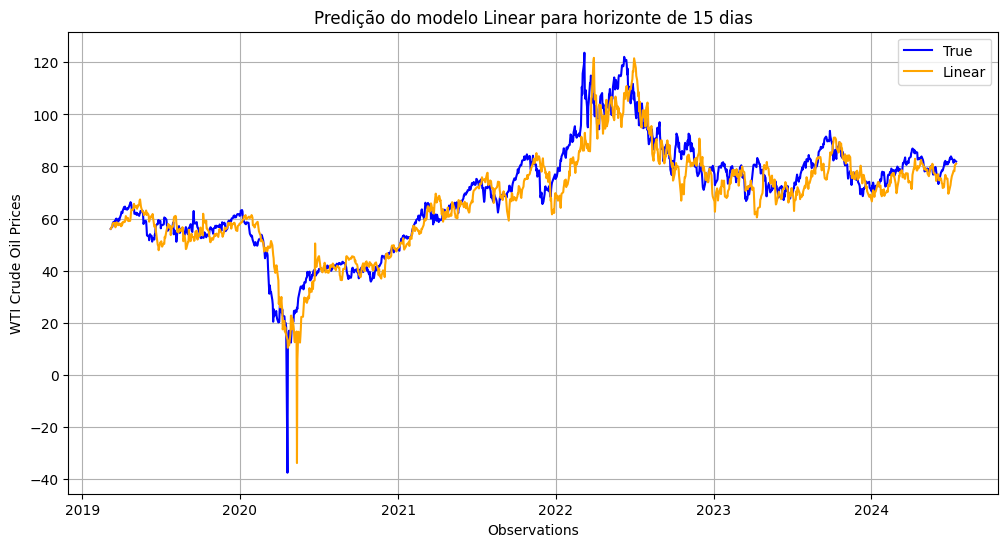

Modelo: Ridge - Tamanho de y_pred: 1344


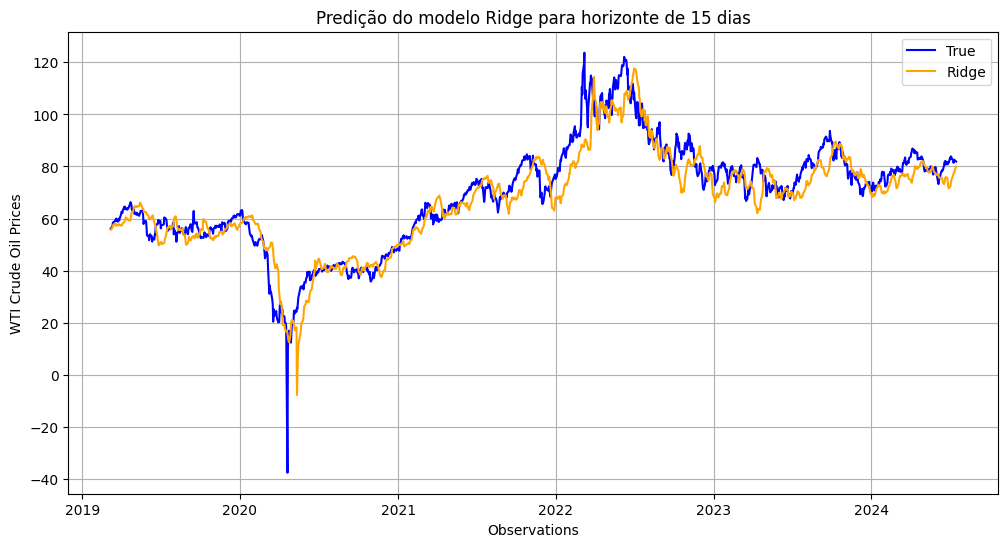

In [254]:
# Plotar previsões vs valores reais para cada modelo e horizonte com valores desescalados
for horizon in yht.keys():  # Agora estamos lidando com 10 horizontes
    X = Xht
    y_test = yht[horizon]  # Obtém o y_test correto para cada horizonte
    y_test = y_scaler.inverse_transform(y_test.reshape(-1,1))  # Desescala o y_test
    print(f"Horizonte: {horizon} - Tamanho de y_test: {len(y_test)}")  # Adicionando print para y_test
    for name in models.keys():
        y_pred = results[horizon][name]["y_pred"]
        dt_x = Ht[horizon]
        
        print(f"Modelo: {name} - Tamanho de y_pred: {len(y_pred)}")  # Adicionando print para y_pred
        
        # Ajustar os tamanhos para garantir compatibilidade
        min_len = min(len(y_test), len(y_pred))
        y_test_aligned = y_test[-min_len:]
        y_pred_aligned = y_pred[-min_len:]
        
        plot_predictions(y_test_aligned, y_pred_aligned, name, horizon, Ht[horizon])

# Modelos horizontes -> predição mensal

In [261]:
X_test[0].reshape(1,-1)

array([[0.26618117, 0.83098592, 0.62741427, 0.25824062, 0.39797901,
        0.86346469, 0.27026826, 0.80602267, 0.63330517, 0.26319288,
        0.40445654, 0.86289498, 0.2767333 , 0.83978773, 0.62830185,
        0.26223081, 0.40458609, 0.84769721, 0.2808947 , 0.84691836,
        0.63022293, 0.26121017, 0.41482057, 0.84256538, 0.29025786,
        0.85684902, 0.62790061, 0.2612282 , 0.41054541, 0.8426324 ,
        0.30943004, 0.86108723, 0.63286745, 0.26346325, 0.42375955,
        0.84713197, 0.31113918, 0.86577939, 0.62866661, 0.25929506,
        0.41818888, 0.84637013, 0.30370811, 0.86562673, 0.63085518,
        0.25993718, 0.41417282, 0.84472133, 0.29568254, 0.86014318,
        0.63174885, 0.26111554, 0.41417282, 0.8462439 , 0.30757227,
        0.87126696, 0.63040531, 0.25955867, 0.40691799, 0.84266703,
        0.30905848, 0.87359697, 0.63293432, 0.2598358 , 0.40419743,
        0.83174318, 0.30727502, 0.88157525, 0.63194947, 0.25837806,
        0.40380878, 0.83125167, 0.32013079, 0.89

In [262]:
results[1]["Linear"]["model"].predict(X_test[0].reshape(1,-1))

array([0.33672171])

In [271]:
xx, yy = create_features_and_targets_for_month(src_df, '2024-05-20', window_size=30, target_column=config["target_col"])

In [305]:
# filter best models
best_models = {}
for h, hdict in results.items():
    for name, mdict in hdict.items():
        if "is_best" in mdict:
            best_models[h] = mdict["model"]
    

In [306]:
[id(m) for m in best_models.values()]

[128320465757200,
 128320465761232,
 128320465760464,
 128320465757248,
 128320465759648,
 128320465762192,
 128320465759264,
 128320465760800,
 128320465761280,
 128320465757680,
 128320465764160,
 128320649534176,
 128320649539936,
 128320649540944,
 128320649529328,
 128320649528128]

In [309]:
predict_until_end(best_models, src_df, "2024-05-20", 30, config["target_col"], X_scaler, y_scaler)



/home/dasilva/workspace/lamelas/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


(array([79.8 , 79.26, 77.57, 76.87, 77.72, 79.83, 79.23, 77.91, 76.99]),
 array([[80.228449  ],
        [79.94991021],
        [80.14642464],
        [79.6515297 ],
        [79.44140807],
        [79.29418056],
        [79.14279649],
        [78.36266879],
        [78.59794823]]),
 DatetimeIndex(['2024-05-20', '2024-05-21', '2024-05-22', '2024-05-23',
                '2024-05-24', '2024-05-28', '2024-05-29', '2024-05-30',
                '2024-05-31'],
               dtype='datetime64[ns]', name='Date', freq=None))

In [91]:
# Função para prever preços usando múltiplos horizontes temporais a partir do dia 20
def make_predictions_for_remaining_days(models: dict, scaled_data, start_index, window_size=30, max_horizon=10):
    """
    inputs:
        - models: nested dict with models for each horizon
            { horizon int:
                { model_name str: 
                    {   model: model,
                        RMSE: rmse,
                        MSE: mse,
                        MAPE: mape,
                        R²: r2,
                        y_pred: y_pred,
                        is_best: bool (default False)
                    }
                }
            }
        - scaled_data: scaled data
        - start_index: index to start predictions
        
        
    """
    predictions = []
    for horizon in range(1, max_horizon + 1):
        if start_index + horizon - 1 >= len(scaled_data):
            break
        # Ajustar o tamanho da janela de acordo com o horizonte
        X_input = scaled_data[start_index - window_size + horizon:start_index + horizon].flatten()
        X_input = X_input.reshape(1, -1)  # Garantir que X_input seja 2D

        # Garantir que a entrada tenha o número correto de features
        if X_input.shape[1] != model.n_features_in_:
            # Preencher com valores reais do último dia se faltar features
            last_real_day = scaled_data[start_index - 1][:model.n_features_in_ - X_input.shape[1]]
            X_input = np.concatenate([X_input.flatten(), last_real_day]).reshape(1, -1)

        prediction = model.predict(X_input)[0]
        predictions.append(prediction)
    return predictions

# "Dumb" model vs pred

## Linear Regression

Agora já não temos o problema das 180 features, em que o modelo atribuía às variáveis independentes (S&P500, Gold, Silver, EURRUB e EURUSD) os valores do último dia disponível, ou seja, no dia 21 ainda tínhamos os dados reais disponíveis (dia 20), mas dia 22 atribuíamos a essas variáveis os mesmos valores de dia 20, até ao final do mês. Agora a partir do dia 20 de cada mês, uma vez que temos dez horizontes disponíveis, vamos usar o nº de horizontes necessários para prever o preço do WTI Crude Oil até ao final de cada mês. Posteriormente, calculamos a média do preço do WTI nesse mês e comparamos com a média do mês anterior.

In [ ]:
# Função para calcular os custos usando o modelo "Dumb" e o modelo "Previsto"
def calculate_costs(model, scaled_data, window_size=30, max_horizon=10):
    dumb_total_cost = 0
    pred_total_cost = 0
    last_month_avg = None
    already_bought_months = set()

    for i in range(window_size, len(scaled_data), 30):  # Assumindo 30 dias por mês para simplificação
        # Calcular o índice de início e fim do mês
        month_start_index = i
        month_end_index = min(i + 30, len(scaled_data))

        # Calcular a média do mês anterior
        if last_month_avg is None:
            last_month_avg = np.mean(scaled_data[month_start_index - 30:month_start_index, 0])

        # Modelo Dumb: comprar combustível para o mês atual ao preço do mês anterior
        dumb_total_cost += last_month_avg

        # Modelo Previsto: prever os preços dos dias restantes no mês e calcular a média
        predictions = make_predictions_for_remaining_days(
            model, scaled_data, month_start_index + 19, window_size=window_size, max_horizon=max_horizon)

        # Combinar os dados reais até o dia 20 com as previsões
        full_month_data = np.concatenate([scaled_data[month_start_index:month_start_index + 20, 0], predictions])
        current_month_avg = np.mean(full_month_data)

        # Decisão de compra com base nas regras definidas
        current_month = (month_start_index // 30) + 1
        if current_month_avg > last_month_avg:
            # Comprar combustível para o mês atual e para o mês seguinte
            if current_month not in already_bought_months:
                pred_total_cost += last_month_avg  # Custo do mês atual
                already_bought_months.add(current_month)
            if current_month + 1 not in already_bought_months:
                pred_total_cost += last_month_avg  # Custo do mês seguinte
                already_bought_months.add(current_month + 1)
        else:
            if current_month not in already_bought_months:
                pred_total_cost += last_month_avg
                already_bought_months.add(current_month)

        # Atualizar a média do mês anterior
        last_month_avg = np.mean(scaled_data[month_start_index:month_end_index, 0])

    return dumb_total_cost, pred_total_cost

In [95]:
filtered_data

WTI Crude Oil Prices   S&P500     Gold   Silver  EUR/USD  EUR/RUB
Date                                                                         
1994-01-04                 14.67   466.89   393.85   5.2400   1.1246   1.1088
1994-01-05                 15.34   467.55   391.20   5.0900   1.1252   1.1154
1994-01-06                 15.42   467.12   388.90   5.1200   1.1252   1.1189
1994-01-07                 15.32   469.90   387.10   5.0100   1.1293   1.1148
1994-01-10                 14.67   475.27   384.60   5.0400   1.1269   1.1305
...                          ...      ...      ...      ...      ...      ...
2024-07-08                 82.33  5572.85  2359.13  30.7634   1.0824  95.1604
2024-07-09                 81.41  5576.98  2364.09  30.8020   1.0813  95.5021
2024-07-11                 82.62  5584.54  2415.48  31.4640   1.0868  95.1059
2024-07-12                 82.21  5615.35  2411.43  30.7885   1.0907  95.7118
2024-07-15                 81.91  5631.22  2422.27  30.6769   1.0894  96.2973

[7639 rows x 6 columns]

In [ ]:
# Aplicar o modelo Linear Regression para fazer previsões e calcular os custos
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
dumb_total_cost, pred_total_cost = calculate_costs(
    linear_reg_model, scaled_data, window_size=30, max_horizon=10)

In [ ]:
# Exibir os resultados
print(f"Total cost with dumb model: {dumb_total_cost:.2f}")
print(f"Total cost with predicted model: {pred_total_cost:.2f}")

Total cost with dumb model: 128.33
Total cost with predicted model: 125.89


In [ ]:
# Função para fazer a inversão do scaling
def inverse_transform(scaler, data, y_data):
    data_reshaped = np.concatenate((y_data.reshape(-1, 1), data), axis=1)
    data_descaled = scaler.inverse_transform(data_reshaped)
    return data_descaled[:, 0]

In [ ]:
# Função para calcular os custos, agora utilizando os valores reais (desescalados)
def calculate_costs(model, scaled_data, window_size=30, max_horizon=10):
    dumb_total_cost = 0
    pred_total_cost = 0
    already_bought_month = set()

    for i in range(window_size, len(scaled_data), 30):  # Assumindo 30 dias por mês para simplificação
        month_start_index = i
        month_end_index = min(i + 30, len(scaled_data))

        # Calcular a média do mês anterior em valores reais
        last_month_avg_scaled = np.mean(scaled_data[month_start_index-30:month_start_index, 0])
        last_month_avg = inverse_transform(scaler, np.zeros((1, scaled_data.shape[1] - 1)), np.array([last_month_avg_scaled]))

        # Modelo Dumb: comprar combustível para o mês atual ao preço do mês anterior
        dumb_total_cost += last_month_avg[0]

        # Modelo Previsto: prever os preços dos dias restantes no mês e calcular a média
        predictions = make_predictions_for_remaining_days(
            model, scaled_data, month_start_index + 19, window_size=window_size, max_horizon=max_horizon)

        # Combinar os dados reais até o dia 20 com as previsões e desescalar
        full_month_data_scaled = np.concatenate([scaled_data[month_start_index:month_start_index + 20, 0], predictions])
        full_month_data = inverse_transform(scaler, np.zeros((full_month_data_scaled.shape[0], scaled_data.shape[1] - 1)), full_month_data_scaled)

        current_month_avg = np.mean(full_month_data)

        # Verificar se o combustível do mês atual já foi comprado no mês anterior
        current_month = (month_start_index // 30) + 1
        if current_month not in already_bought_month:
            if current_month_avg > last_month_avg:
                # Comprar combustível para o mês atual e para o mês seguinte
                pred_total_cost += last_month_avg[0]  # Mês atual
                pred_total_cost += last_month_avg[0]  # Mês seguinte
                already_bought_month.add(current_month + 1)
            else:
                # Comprar apenas para o mês atual
                pred_total_cost += last_month_avg[0]

    return dumb_total_cost, pred_total_cost

In [ ]:
# Calcular os custos agora usando os valores reais
dumb_total_cost, pred_total_cost = calculate_costs(
    linear_reg_model, scaled_data, window_size=30, max_horizon=10)

In [ ]:
# Exibir os resultados
print(f"Total cost with dumb model: {dumb_total_cost:.2f}")
print(f"Total cost with predicted model: {pred_total_cost:.2f}")

Total cost with dumb model: 13916.25
Total cost with predicted model: 13643.52


## Ridge

In [ ]:
# Treinar o modelo Ridge Regression
ridge_model = Ridge()
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
ridge_model.fit(X_train, y_train)

Ridge()

In [ ]:
# Aplicar o modelo Ridge Regression para calcular os custos
dumb_total_cost_ridge, pred_total_cost_ridge = calculate_costs(
    ridge_model, scaled_data, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados
print(f"Total cost with dumb model (Ridge Regression): {dumb_total_cost_ridge:.2f}")
print(f"Total cost with predicted model (Ridge Regression): {pred_total_cost_ridge:.2f}")

Total cost with dumb model (Ridge Regression): 13916.25
Total cost with predicted model (Ridge Regression): 13637.53


## Lasso

In [ ]:
# Treinar o modelo Lasso Regression
lasso_model = Lasso(alpha=0.01)  # Usando um alpha mais baixo para o Lasso
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.01)

In [ ]:
# Aplicar o modelo Lasso Regression para calcular os custos
dumb_total_cost_lasso, pred_total_cost_lasso = calculate_costs(
    lasso_model, scaled_data, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados
print(f"Total cost with dumb model (Lasso Regression): {dumb_total_cost_lasso:.2f}")
print(f"Total cost with predicted model (Lasso Regression): {pred_total_cost_lasso:.2f}")

Total cost with dumb model (Lasso Regression): 13916.25
Total cost with predicted model (Lasso Regression): 13698.73


## Elastic Net

In [ ]:
# Treinar o modelo Elastic Net Regression
elastic_net_model = ElasticNet(alpha=0.01, l1_ratio=0.5)  # Usando alpha baixo e l1_ratio de 0.5
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
elastic_net_model.fit(X_train, y_train)

ElasticNet(alpha=0.01)

In [ ]:
# Aplicar o modelo Elastic Net Regression para calcular os custos
dumb_total_cost_elastic_net, pred_total_cost_elastic_net = calculate_costs(
    elastic_net_model, scaled_data, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados
print(f"Total cost with dumb model (Elastic Net Regression): {dumb_total_cost_elastic_net:.2f}")
print(f"Total cost with predicted model (Elastic Net Regression): {pred_total_cost_elastic_net:.2f}")

Total cost with dumb model (Elastic Net Regression): 13916.25
Total cost with predicted model (Elastic Net Regression): 13654.70


## Random Forest Regression

In [ ]:
random_forest_model = RandomForestRegressor()
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
random_forest_model.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
# Aplicar o modelo Random Forest para calcular os custos
dumb_total_cost_rf, pred_total_cost_rf = calculate_costs(
    random_forest_model, scaled_data, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados
print(f"Total cost with dumb model (Random Forest): {dumb_total_cost_rf:.2f}")
print(f"Total cost with predicted model (Random Forest): {pred_total_cost_rf:.2f}")

Total cost with dumb model (Random Forest): 13916.25
Total cost with predicted model (Random Forest): 13648.49


## XGBoost

In [ ]:
# Treinar o modelo XGBoost Regression
xgboost_model = XGBRegressor()
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Aplicar o modelo XGBoost Regression para calcular os custos
dumb_total_cost_xgboost, pred_total_cost_xgboost = calculate_costs(
    xgboost_model, scaled_data, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados
print(f"Total cost with dumb model (XGBoost Regression): {dumb_total_cost_xgboost:.2f}")
print(f"Total cost with predicted model (XGBoost Regression): {pred_total_cost_xgboost:.2f}")

Total cost with dumb model (XGBoost Regression): 13916.25
Total cost with predicted model (XGBoost Regression): 13649.67


## SVR

In [ ]:
# Treinar o modelo SVR
svr_model = SVR(kernel='rbf')
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
svr_model.fit(X_train, y_train)

SVR()

In [ ]:
# Aplicar o modelo SVR para calcular os custos
dumb_total_cost_svr, pred_total_cost_svr = calculate_costs(
    svr_model, scaled_data, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados
print(f"Total cost with dumb model (SVR): {dumb_total_cost_svr:.2f}")
print(f"Total cost with predicted model (SVR): {pred_total_cost_svr:.2f}")

Total cost with dumb model (SVR): 13916.25
Total cost with predicted model (SVR): 13689.16


## Resultados

In [ ]:
# Dicionário com os resultados de todos os modelos
resultados = {
    "Modelo": [
        "Linear Regression",
        "Ridge Regression",
        "Lasso Regression",
        "Elastic Net Regression",
        "Random Forest Regression",
        "XGBoost Regression",
        "SVR"
    ],
    "Total Cost - Dumb Model": [
        dumb_total_cost, 
        dumb_total_cost_ridge, 
        dumb_total_cost_lasso, 
        dumb_total_cost_elastic_net, 
        dumb_total_cost_rf, 
        dumb_total_cost_xgboost, 
        dumb_total_cost_svr
    ],
    "Total Cost - Predicted Model": [
        pred_total_cost, 
        pred_total_cost_ridge, 
        pred_total_cost_lasso, 
        pred_total_cost_elastic_net, 
        pred_total_cost_rf, 
        pred_total_cost_xgboost, 
        pred_total_cost_svr
    ]
}

In [ ]:
# Criar um DataFrame com os resultados
df_resultados = pd.DataFrame(resultados)

In [ ]:
# Calcular a melhoria percentual
df_resultados["Improvement (%)"] = ((df_resultados["Total Cost - Dumb Model"] - df_resultados["Total Cost - Predicted Model"]) / df_resultados["Total Cost - Dumb Model"]) * 100

In [ ]:
# Ordenar o DataFrame pela coluna "Improvement (%)" em ordem decrescente
df_resultados_sorted = df_resultados.sort_values(by="Improvement (%)", ascending=False)

In [ ]:
# Redefinir os índices para que eles fiquem na ordem correta
df_resultados_sorted.reset_index(drop=True, inplace=True)

In [ ]:
# Ajustar a exibição da tabela
print(tabulate(df_resultados_sorted, headers="keys", tablefmt="fancy_grid", numalign="right", stralign="center"))

╒════╤══════════════════════════╤═══════════════════════════╤════════════════════════════════╤═══════════════════╕
│    │          Modelo          │   Total Cost - Dumb Model │   Total Cost - Predicted Model │   Improvement (%) │
╞════╪══════════════════════════╪═══════════════════════════╪════════════════════════════════╪═══════════════════╡
│  0 │     Ridge Regression     │                   13916.3 │                        13637.5 │           2.00286 │
├────┼──────────────────────────┼───────────────────────────┼────────────────────────────────┼───────────────────┤
│  1 │    Linear Regression     │                   13916.3 │                        13643.5 │           1.95982 │
├────┼──────────────────────────┼───────────────────────────┼────────────────────────────────┼───────────────────┤
│  2 │ Random Forest Regression │                   13916.3 │                        13648.5 │           1.92407 │
├────┼──────────────────────────┼───────────────────────────┼───────────────────

Olhando para o modelo Ridge, que foi o modelo que obteve melhores previsões, vemos que o improvement foi de aproximadamente 2%. Tendo em conta os valores apresentados pela DAT de gastos com combustível, entre os anos de 2025 a 2028, temos um valor estimado de 175.414.759,95€. Ou seja, uma melhoria de 2% significaria uma poupança de 3.508.295,2€ ao longo desses 4 anos. 

Se quisermos olhar apenas para o ano de 2025, o valor máximo contratualizado foi pouco mais de 38M€, pelo que um improvement de 2% representa uma poupança de quase 800k.

# Nova tentativa de aplicação do modelo de regressão

Desta vez, tentou fazer-se apenas com os dados de teste. A aplicabilidade do modelo no exemplo de cima estava a ter resultados demasiado elevados para estar a calcular apenas dados de teste, ou seja, estaria a calcular o dumb_bought_sum e o pred_bought_sum para os dados de treino e de teste.

In [ ]:
# Função para dividir os dados em treino e teste novamente
def split_data_for_testing(scaled_data, test_size=0.2):
    split_index = int(len(scaled_data) * (1 - test_size))  # Índice onde começa o teste
    return scaled_data[split_index:], split_index  # Retorna o conjunto de teste e o índice

In [ ]:
# Dividir o conjunto de dados novamente para obter apenas os dados de teste
scaled_data_test, test_start_index = split_data_for_testing(scaled_data, test_size=0.2)

In [ ]:
# Função para calcular os custos apenas no período de teste
def calculate_costs_for_test_only(model, scaled_data, start_index, window_size=30, max_horizon=10):
    dumb_total_cost = 0
    pred_total_cost = 0
    already_bought_month = set()

    for i in range(start_index, len(scaled_data), 30):  # Assumindo 30 dias por mês para simplificação
        month_start_index = i
        month_end_index = min(i + 30, len(scaled_data))

        # Calcular a média do mês anterior em valores reais
        last_month_avg_scaled = np.mean(scaled_data[month_start_index-30:month_start_index, 0])
        last_month_avg = inverse_transform(scaler, np.zeros((1, scaled_data.shape[1] - 1)), np.array([last_month_avg_scaled]))

        # Modelo Dumb: comprar combustível para o mês atual ao preço do mês anterior
        dumb_total_cost += last_month_avg[0]

        # Modelo Previsto: prever os preços dos dias restantes no mês e calcular a média
        predictions = make_predictions_for_remaining_days(
            model, scaled_data, month_start_index + 19, window_size=window_size, max_horizon=max_horizon)

        # Combinar os dados reais até o dia 20 com as previsões e desescalar
        full_month_data_scaled = np.concatenate([scaled_data[month_start_index:month_start_index + 20, 0], predictions])
        full_month_data = inverse_transform(scaler, np.zeros((full_month_data_scaled.shape[0], scaled_data.shape[1] - 1)), full_month_data_scaled)

        current_month_avg = np.mean(full_month_data)

        # Verificar se o combustível do mês atual já foi comprado no mês anterior
        current_month = (month_start_index // 30) + 1
        if current_month not in already_bought_month:
            if current_month_avg > last_month_avg:
                # Comprar combustível para o mês atual e para o mês seguinte
                pred_total_cost += last_month_avg[0]  # Mês atual
                pred_total_cost += last_month_avg[0]  # Mês seguinte
                already_bought_month.add(current_month + 1)
            else:
                # Comprar apenas para o mês atual
                pred_total_cost += last_month_avg[0]

    return dumb_total_cost, pred_total_cost

## Linear Regression

In [ ]:
# Calcular os custos apenas para o período de teste
dumb_total_cost_test, pred_total_cost_test = calculate_costs_for_test_only(
    linear_reg_model, scaled_data, start_index=test_start_index, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados
print(f"Total cost with dumb model (Test Only): {dumb_total_cost_test:.2f}")
print(f"Total cost with predicted model (Test Only): {pred_total_cost_test:.2f}")

Total cost with dumb model (Test Only): 3458.78
Total cost with predicted model (Test Only): 3366.54


In [ ]:
# Armazenar os resultados
dumb_bought_sum = dumb_total_cost_test
pred_bought_sum = pred_total_cost_test

In [ ]:
# Exibir as somas totais
print(f"Dumb Model Bought Sum (Test Period): {dumb_bought_sum:.2f}")
print(f"Predicted Model Bought Sum (Test Period): {pred_bought_sum:.2f}")

Dumb Model Bought Sum (Test Period): 3458.78
Predicted Model Bought Sum (Test Period): 3366.54


## Ridge

In [ ]:
# Treinar o modelo Ridge Regression
ridge_model = Ridge()
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
ridge_model.fit(X_train, y_train)

Ridge()

In [ ]:
# Calcular os custos apenas para o período de teste usando Ridge Regression
dumb_total_cost_ridge_test, pred_total_cost_ridge_test = calculate_costs_for_test_only(
    ridge_model, scaled_data, start_index=test_start_index, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados para Ridge Regression
print(f"Total cost with dumb model (Ridge Regression - Test Only): {dumb_total_cost_ridge_test:.2f}")
print(f"Total cost with predicted model (Ridge Regression - Test Only): {pred_total_cost_ridge_test:.2f}")

Total cost with dumb model (Ridge Regression - Test Only): 3458.78
Total cost with predicted model (Ridge Regression - Test Only): 3446.17


In [ ]:
# Armazenar os resultados para Ridge Regression
dumb_bought_sum_ridge = dumb_total_cost_ridge_test
pred_bought_sum_ridge = pred_total_cost_ridge_test

In [ ]:
# Exibir as somas totais para Ridge Regression
print(f"Dumb Model Bought Sum (Ridge Regression - Test Period): {dumb_bought_sum_ridge:.2f}")
print(f"Predicted Model Bought Sum (Ridge Regression - Test Period): {pred_bought_sum_ridge:.2f}")

Dumb Model Bought Sum (Ridge Regression - Test Period): 3458.78
Predicted Model Bought Sum (Ridge Regression - Test Period): 3446.17


## Lasso

In [ ]:
# Treinar o modelo Lasso Regression
lasso_model = Lasso(alpha=0.01)  # Usando um alpha mais baixo para o Lasso
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.01)

In [ ]:
# Calcular os custos apenas para o período de teste usando Lasso Regression
dumb_total_cost_lasso_test, pred_total_cost_lasso_test = calculate_costs_for_test_only(
    lasso_model, scaled_data, start_index=test_start_index, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados para Lasso Regression
print(f"Total cost with dumb model (Lasso Regression - Test Only): {dumb_total_cost_lasso_test:.2f}")
print(f"Total cost with predicted model (Lasso Regression - Test Only): {pred_total_cost_lasso_test:.2f}")

Total cost with dumb model (Lasso Regression - Test Only): 3458.78
Total cost with predicted model (Lasso Regression - Test Only): 3367.82


In [ ]:
# Armazenar os resultados para Lasso Regression
dumb_bought_sum_lasso = dumb_total_cost_lasso_test
pred_bought_sum_lasso = pred_total_cost_lasso_test

In [ ]:
# Exibir as somas totais para Lasso Regression
print(f"Dumb Model Bought Sum (Lasso Regression - Test Period): {dumb_bought_sum_lasso:.2f}")
print(f"Predicted Model Bought Sum (Lasso Regression - Test Period): {pred_bought_sum_lasso:.2f}")

Dumb Model Bought Sum (Lasso Regression - Test Period): 3458.78
Predicted Model Bought Sum (Lasso Regression - Test Period): 3367.82


## Elastic Net

In [ ]:
# Treinar o modelo Elastic Net Regression
elastic_net_model = ElasticNet(alpha=0.01, l1_ratio=0.5)  # Usando alpha baixo e l1_ratio de 0.5
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
elastic_net_model.fit(X_train, y_train)

ElasticNet(alpha=0.01)

In [ ]:
# Imprimir previsões para Elastic Net Regression para verificação
y_pred_elastic_net = elastic_net_model.predict(X_test)
print(f"Elastic Net Predictions: {y_pred_elastic_net[:5]}")  # Exibir as primeiras 5 previsões para inspeção

Elastic Net Predictions: [0.55662506 0.5559751  0.55670438 0.5571769  0.5586519 ]


In [ ]:
# Calcular os custos apenas para o período de teste usando Elastic Net Regression
dumb_total_cost_elastic_net_test, pred_total_cost_elastic_net_test = calculate_costs_for_test_only(
    elastic_net_model, scaled_data, start_index=test_start_index, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados para Elastic Net Regression
print(f"Total cost with dumb model (Elastic Net Regression - Test Only): {dumb_total_cost_elastic_net_test:.2f}")
print(f"Total cost with predicted model (Elastic Net Regression - Test Only): {pred_total_cost_elastic_net_test:.2f}")

Total cost with dumb model (Elastic Net Regression - Test Only): 3458.78
Total cost with predicted model (Elastic Net Regression - Test Only): 3366.25


In [ ]:
# Armazenar os resultados para Elastic Net Regression
dumb_bought_sum_elastic_net = dumb_total_cost_elastic_net_test
pred_bought_sum_elastic_net = pred_total_cost_elastic_net_test

In [ ]:
# Exibir as somas totais para Elastic Net Regression
print(f"Dumb Model Bought Sum (Elastic Net Regression - Test Period): {dumb_bought_sum_elastic_net:.2f}")
print(f"Predicted Model Bought Sum (Elastic Net Regression - Test Period): {pred_bought_sum_elastic_net:.2f}")

Dumb Model Bought Sum (Elastic Net Regression - Test Period): 3458.78
Predicted Model Bought Sum (Elastic Net Regression - Test Period): 3366.25


## Random Forest Regression

In [ ]:
# Treinar o modelo Random Forest Regression
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
random_forest_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, random_state=42)

In [ ]:
# Imprimir previsões para Random Forest para verificação
y_pred_random_forest = random_forest_model.predict(X_test)
print(f"Random Forest Predictions: {y_pred_random_forest[:5]}")

Random Forest Predictions: [0.57228069 0.56018728 0.57609381 0.57544046 0.59209913]


In [ ]:
# Calcular os custos apenas para o período de teste usando Random Forest
dumb_total_cost_rf_test, pred_total_cost_rf_test = calculate_costs_for_test_only(
    random_forest_model, scaled_data, start_index=test_start_index, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados para Random Forest
print(f"Total cost with dumb model (Random Forest - Test Only): {dumb_total_cost_rf_test:.2f}")
print(f"Total cost with predicted model (Random Forest - Test Only): {pred_total_cost_rf_test:.2f}")

Total cost with dumb model (Random Forest - Test Only): 3458.78
Total cost with predicted model (Random Forest - Test Only): 3446.17


In [ ]:
# Armazenar os resultados para Random Forest
dumb_bought_sum_rf = dumb_total_cost_rf_test
pred_bought_sum_rf = pred_total_cost_rf_test

In [ ]:
# Exibir as somas totais para Random Forest
print(f"Dumb Model Bought Sum (Random Forest - Test Period): {dumb_bought_sum_rf:.2f}")
print(f"Predicted Model Bought Sum (Random Forest - Test Period): {pred_bought_sum_rf:.2f}")

Dumb Model Bought Sum (Random Forest - Test Period): 3458.78
Predicted Model Bought Sum (Random Forest - Test Period): 3446.17


## XGBoost

In [ ]:
# Treinar o modelo XGBoost Regression
xgboost_model = XGBRegressor()
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Calcular os custos apenas para o período de teste usando XGBoost
dumb_total_cost_xgboost_test, pred_total_cost_xgboost_test = calculate_costs_for_test_only(
    xgboost_model, scaled_data, start_index=test_start_index, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados para XGBoost
print(f"Total cost with dumb model (XGBoost Regression - Test Only): {dumb_total_cost_xgboost_test:.2f}")
print(f"Total cost with predicted model (XGBoost Regression - Test Only): {pred_total_cost_xgboost_test:.2f}")

Total cost with dumb model (XGBoost Regression - Test Only): 3458.78
Total cost with predicted model (XGBoost Regression - Test Only): 3367.59


In [ ]:
# Armazenar os resultados para XGBoost
dumb_bought_sum_xgboost = dumb_total_cost_xgboost_test
pred_bought_sum_xgboost = pred_total_cost_xgboost_test

In [ ]:
# Exibir as somas totais para XGBoost
print(f"Dumb Model Bought Sum (XGBoost Regression - Test Period): {dumb_bought_sum_xgboost:.2f}")
print(f"Predicted Model Bought Sum (XGBoost Regression - Test Period): {pred_bought_sum_xgboost:.2f}")

Dumb Model Bought Sum (XGBoost Regression - Test Period): 3458.78
Predicted Model Bought Sum (XGBoost Regression - Test Period): 3367.59


## SVR

In [ ]:
# Treinar o modelo SVR
svr_model = SVR(kernel='rbf')
X_train, X_test, y_train, y_test = split_and_scale_data(features_targets[1][0], features_targets[1][1], test_size=0.2)
svr_model.fit(X_train, y_train)

SVR()

In [ ]:
# Calcular os custos apenas para o período de teste usando SVR
dumb_total_cost_svr_test, pred_total_cost_svr_test = calculate_costs_for_test_only(
    svr_model, scaled_data, start_index=test_start_index, window_size=30, max_horizon=10
)

In [ ]:
# Exibir os resultados para SVR
print(f"Total cost with dumb model (SVR - Test Only): {dumb_total_cost_svr_test:.2f}")
print(f"Total cost with predicted model (SVR - Test Only): {pred_total_cost_svr_test:.2f}")

Total cost with dumb model (SVR - Test Only): 3458.78
Total cost with predicted model (SVR - Test Only): 3381.10


In [ ]:
# Armazenar os resultados para SVR
dumb_bought_sum_svr = dumb_total_cost_svr_test
pred_bought_sum_svr = pred_total_cost_svr_test

In [ ]:
# Exibir as somas totais para SVR
print(f"Dumb Model Bought Sum (SVR - Test Period): {dumb_bought_sum_svr:.2f}")
print(f"Predicted Model Bought Sum (SVR - Test Period): {pred_bought_sum_svr:.2f}")

Dumb Model Bought Sum (SVR - Test Period): 3458.78
Predicted Model Bought Sum (SVR - Test Period): 3381.10


## Resultados numa tabela

In [ ]:
# Dicionário com os resultados de todos os modelos após a análise do período de teste
resultados_test = {
    "Modelo": [
        "Linear Regression",
        "Ridge Regression",
        "Lasso Regression",
        "Elastic Net Regression",
        "Random Forest Regression",
        "XGBoost Regression",
        "SVR"
    ],
    "Total Cost - Dumb Model": [
        dumb_total_cost_test, 
        dumb_total_cost_ridge_test, 
        dumb_total_cost_lasso_test, 
        dumb_total_cost_elastic_net_test, 
        dumb_total_cost_rf_test, 
        dumb_total_cost_xgboost_test, 
        dumb_total_cost_svr_test
    ],
    "Total Cost - Predicted Model": [
        pred_total_cost_test, 
        pred_total_cost_ridge_test, 
        pred_total_cost_lasso_test, 
        pred_total_cost_elastic_net_test, 
        pred_total_cost_rf_test, 
        pred_total_cost_xgboost_test, 
        pred_total_cost_svr_test
    ]
}

In [ ]:
# Criar um DataFrame com os resultados
df_resultados_test = pd.DataFrame(resultados_test)

In [ ]:
# Calcular a melhoria percentual
df_resultados_test["Improvement (%)"] = ((df_resultados_test["Total Cost - Dumb Model"] - df_resultados_test["Total Cost - Predicted Model"]) / df_resultados_test["Total Cost - Dumb Model"]) * 100

In [ ]:
# Ordenar o DataFrame pela coluna "Improvement (%)" em ordem decrescente
df_resultados_test_sorted = df_resultados_test.sort_values(by="Improvement (%)", ascending=False)

In [ ]:
# Redefinir os índices para que eles fiquem na ordem correta
df_resultados_test_sorted.reset_index(drop=True, inplace=True)

In [ ]:
# Ajustar a exibição da tabela
print(tabulate(df_resultados_test_sorted, headers="keys", tablefmt="fancy_grid", numalign="right", stralign="center"))

╒════╤══════════════════════════╤═══════════════════════════╤════════════════════════════════╤═══════════════════╕
│    │          Modelo          │   Total Cost - Dumb Model │   Total Cost - Predicted Model │   Improvement (%) │
╞════╪══════════════════════════╪═══════════════════════════╪════════════════════════════════╪═══════════════════╡
│  0 │  Elastic Net Regression  │                   3458.78 │                        3366.25 │           2.67516 │
├────┼──────────────────────────┼───────────────────────────┼────────────────────────────────┼───────────────────┤
│  1 │    Linear Regression     │                   3458.78 │                        3366.54 │           2.66675 │
├────┼──────────────────────────┼───────────────────────────┼────────────────────────────────┼───────────────────┤
│  2 │    XGBoost Regression    │                   3458.78 │                        3367.59 │           2.63654 │
├────┼──────────────────────────┼───────────────────────────┼───────────────────

Uma coisa que não está a ser considerada nas condições das previsões do "dumb" model e do pred model, é o facto de podermos adquirir combustível apenas para o mês seguinte. Ou seja, imaginemos que perguntamos ao modelo se o combustível do mês atual já foi adquirido no mês anterior. Caso essa resposta seja afirmativa e a média do mês atual seja maior que a do mês anterior, eu devo adquirir o combustível do mês seguinte. O que se fez até agora foi verificar essa condição para não duplicarmos as compras, mas ao mesmo tempo, ou se comprava só o mês atual ou o mês atual mais o mês seguinte, esquecendo-nos que podemos comprar só o mês seguinte.

# Dashboard - "dumb" vs pred 

In [ ]:
import plotly.graph_objs as go
from dash import Dash, dcc, html
from dash.dependencies import Input, Output
from datetime import datetime

In [ ]:
# Inicializar o segundo app do Dash
app2 = Dash(__name__)

In [ ]:
# Configurações de anos, meses e modelos
years = list(range(2018, 2025))  # Anos do período de teste
months = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]
model_names = [
    "Linear Regression", "Ridge Regression", "Lasso Regression",
    "Elastic Net Regression", "Random Forest Regression",
    "XGBoost Regression", "SVR"
]

In [ ]:
# Função para calcular a média cumulativa até o dia 20 do mês atual
def calculate_cumulative_average(data, year, month):
    month_index = months.index(month) + 1
    filtered_data = data[(data.index.year == year) & (data.index.month == month_index)]
    if not filtered_data.empty:
        cumulative_average = filtered_data[:20].mean()[0]  # Média até o dia 20
        return cumulative_average
    return None

In [ ]:
# Função para calcular a média do mês anterior
def calculate_previous_month_average(data, year, month):
    month_index = months.index(month)
    if month_index == 0:  # Se for janeiro
        prev_year = year - 1
        prev_month_index = 12  # Dezembro
    else:
        prev_year = year
        prev_month_index = month_index

    filtered_data = data[(data.index.year == prev_year) & (data.index.month == prev_month_index)]
    if not filtered_data.empty:
        previous_month_average = filtered_data.mean()[0]
        return previous_month_average
    return None

In [ ]:
# Função para verificar se o combustível do mês atual já foi adquirido
def check_if_fuel_bought(already_bought_months, current_month):
    if current_month in already_bought_months:
        return "O combustível do mês atual já foi adquirido no mês anterior."
    else:
        return "O combustível do mês atual ainda não foi adquirido."

In [ ]:
# Layout do Dash
app2.layout = html.Div([
    html.H1("Dashboard de Aquisição de Combustível"),
    dcc.Dropdown(
        id='model-dropdown',
        options=[{'label': model, 'value': model} for model in model_names],
        value=model_names[0]  # Modelo inicial selecionado
    ),
    dcc.Dropdown(
        id='year-dropdown',
        options=[{'label': str(year), 'value': year} for year in years],
        value=years[0]  # Ano inicial selecionado
    ),
    dcc.Dropdown(
        id='month-dropdown',
        options=[{'label': month, 'value': month} for month in months],
        value=months[0]  # Mês inicial selecionado
    ),
    html.Div(id='output-info', style={'margin-top': '20px', 'font-weight': 'bold'}),
    html.Button('Calcular Média do Mês Atual', id='calculate-button', n_clicks=0),
    html.Div(id='output-average', style={'margin-top': '20px', 'font-weight': 'bold'})
])

In [ ]:
# Callback para atualizar as informações iniciais do dashboard
@app2.callback(
    Output('output-info', 'children'),
    [Input('model-dropdown', 'value'),
     Input('year-dropdown', 'value'),
     Input('month-dropdown', 'value')]
)
def update_initial_info(selected_model, selected_year, selected_month):
    # Calcular médias
    previous_month_avg = calculate_previous_month_average(scaled_data_test, selected_year, selected_month)
    cumulative_avg = calculate_cumulative_average(scaled_data_test, selected_year, selected_month)

    if previous_month_avg is None or cumulative_avg is None:
        return "Dados insuficientes para calcular as médias."

    # Verificar se o combustível do mês atual já foi adquirido
    current_month = (selected_year - 2018) * 12 + months.index(selected_month) + 1
    acquisition_message = check_if_fuel_bought(already_bought_months, current_month)

    # Exibir as médias calculadas e a mensagem sobre aquisição
    return [
        f"Média do Mês Anterior: {previous_month_avg:.2f}",
        html.Br(),
        f"Média Cumulativa do Mês Atual até o Dia 20: {cumulative_avg:.2f}",
        html.Br(),
        acquisition_message
    ]

In [ ]:
# Callback para calcular e exibir a média do mês atual após clicar no botão
@app2.callback(
    Output('output-average', 'children'),
    [Input('calculate-button', 'n_clicks')],
    [Input('model-dropdown', 'value'),
     Input('year-dropdown', 'value'),
     Input('month-dropdown', 'value')]
)
def calculate_current_month_average(n_clicks, selected_model, selected_year, selected_month):
    if n_clicks > 0:
        # Calcular a média do mês atual após o dia 20
        current_month_avg = calculate_cumulative_average(scaled_data_test, selected_year, selected_month)
        
        if current_month_avg is None:
            return "Dados insuficientes para calcular a média do mês atual."

        # Determinar se deve comprar apenas para o mês atual ou também para o próximo
        previous_month_avg = calculate_previous_month_average(scaled_data_test, selected_year, selected_month)
        if current_month_avg > previous_month_avg:
            return "Comprar combustível para o mês atual e para o mês seguinte."
        else:
            return "Comprar combustível apenas para o mês atual."

In [ ]:
# Rodar o app no modo inline do Jupyter Notebook em uma porta diferente
app2.run_server(mode='inline', port=8051)

O objetivo deste dashboard será aproximar o trabalho à realidade operacional da DAT, permitindo ter acesso aos dados do WTI Crude Oil e saber, depois de selecionar o modelo, ano e mês, qual foi a média do mês anterior, assim como calcular a média do mês atual.

Depois de fazer isto, deverá aparecer a comparação dos dois valores, indicando à pessoa que está a usar o dashboard que, como a média deste mês será maior que a do mês anterior, deverá comprar combustível para este mês e para o próximo.

No entanto, antes de isto acontecer deveria aparecer uma mensagem a indicar se o combustível deste mês já foi adquirido no mês anterior. Caso já tenha sido adquirido, se a média do mês atual for maior que a do mês anterior devo apenas adquirir o combustível do mês seguinte. Caso ainda não tenha sido adquirido, devo obrigatoriamente adquirir combustível para o mês atual e, se a média for maior que a do mês anterior, posso fazê lo para o mês seguinte também.

Por forma a simplificar tudo, deixando essas opções a cargo do utilizador do dashboard, poderíamos apenas deixar visível a média do mês anterior e qual é a previsão para a média do mês atual. Posteriormente, poderia ser emitida uma mensagem a dizer que a média do mês atual será maior ou menor que a do mês anterior, e pôr a verde caso fosse maior e a vermelho caso fosse menor, indicando que será melhor ou pior adquirir mais combustível, respetivamente.